# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, see [this forum post](https://carnd-forums.udacity.com/cq/viewquestion.action?spaceKey=CAR&id=29496372&questionTitle=finding-lanes---import-cv2-fails-even-though-python-in-the-terminal-window-has-no-problem-with-import-cv2) for more troubleshooting tips.**  

## Import Packages

In [27]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


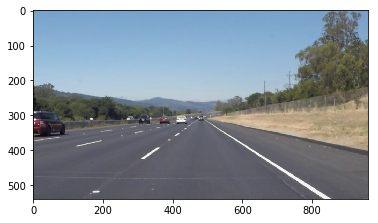

In [28]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [29]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            print(line)
    """
    #print("Start image.")
    ## Plan:
    ## Find the average of each value (y1, y2...)
    ## For each one if the x values are less than the average it is on the left.
    ## Otherwise, it is on the right.
    ## For each one if the y values are less than the average it is on the bottom.
    ## Otherwise, it is on the top.
    ## Find the far left, the far right of each.
    ## 
    
    
    long_lines = []
    average_slope = 0
    ##print(type(lines), lines.shape)
    ## Test
    #verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (130, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    imshape = img.shape
    cv2.line(img, (imshape[1] - 380, 340), (410,340), [0, 0, 255], 10)
    cv2.line(img, (410,340), (130, imshape[0]), [0, 0, 255], 10)
    cv2.line(img, (imshape[1] - 380, 340), (410,340), [0, 0, 255], 10)
    cv2.line(img, (imshape[1] - 380, 340), (imshape[1], imshape[0]), [0, 0, 255], 10)
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            line_len = ((x1 - x2) ** 2 + (y1 - y2) ** 2) ** 0.5
            if line_len >= 100:
                long_lines.append(np.array([[x1, y1, x2, y2]]))
                temp_slope = ((y2-y1)/(x2-x1))
                average_slope += temp_slope
                cv2.line(img, (x1, y1), (x2, y2), [0, 255, 0], thickness)
                
    long_lines = np.array(long_lines)
    print(type(long_lines), long_lines.shape)
    average_slope /= long_lines.shape[0]
    
    ##left_lines = []
    ##right_lines = []
    
    left_average_x = 0
    left_average_y = 0
    right_average_x = 0
    right_average_y = 0
    
    left_average_slope = 0
    right_average_slope = 0
    
    left_total = 0
    right_total = 0
    
    for line in long_lines:
        for x1, y1, x2, y2 in line:
            ##cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            temp_slope = ((y2-y1)/(x2-x1))
            if temp_slope >= average_slope:
                ## On the left side.
                ##left_lines.append(np.array([[x1, y1, x2, y2]]))
                left_average_x += x1 + x2
                left_average_y += y1 + y2
                left_average_slope += ((y2-y1)/(x2-x1))
                left_total += 1
            else:
                ## On the right side.
                ##right_lines.append(np.array([[x1, y1, x2, y2]]))
                right_average_x += x1 + x2
                right_average_y += y1 + y2
                right_average_slope += ((y2-y1)/(x2-x1))
                right_total += 1
        
    try:
        left_average_x /= left_total * 2
        left_average_y /= left_total * 2
        left_average_slope /= left_total
    except:
        left_average_x = 1
        left_average_y = 1
        left_average_slope = 1
        
    try:
        right_average_x /= right_total * 2
        right_average_y /= right_total * 2
        right_average_slope /= right_total
    except:
        right_average_x = 1
        right_average_y = 1
        right_average_slope = 1
    
    ## Calculate the new lines to show.
    top_limit = 360
    bottom_limit = img.shape[0]
    
    ## y = mx + b
    ## b = y - mx
    ## x = (y-b)/m
    try:
        left_b = left_average_y - left_average_slope * left_average_x
        left_top_x = (top_limit - left_b) / left_average_slope
        left_bottom_x = (bottom_limit - left_b) / left_average_slope
    except:
        left_top_x = 1
        left_bottom_x = 1
    
    try:
        right_b = right_average_y - right_average_slope * right_average_x
        right_top_x = (top_limit - right_b) / right_average_slope
        right_bottom_x = (bottom_limit - right_b) / right_average_slope
    except:
        right_top_x = 1
        right_bottom_x = 1

    if np.isnan(left_bottom_x) or np.isnan(left_top_x):
        left_bottom_x = 1
        left_top_x = 1
        
    if np.isnan(right_bottom_x) or np.isnan(right_top_x):
        right_bottom_x = 1
        right_top_x = 1
    
    ##print(left_bottom_x, left_top_x, right_bottom_x, right_top_x)
    print(left_bottom_x, bottom_limit, left_top_x, top_limit)
    print(right_bottom_x, bottom_limit, right_top_x, top_limit)
    cv2.line(img, (int(left_bottom_x), bottom_limit), (int(left_top_x), top_limit), color, thickness*2)
    cv2.line(img, (int(right_bottom_x), bottom_limit), (int(right_top_x), top_limit), color, thickness*2)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [30]:
import os
os.listdir("test_images/")

['challenge.jpg',
 'solidWhiteCurve.jpg',
 'solidWhiteRight.jpg',
 'solidYellowCurve.jpg',
 'solidYellowCurve2.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

<class 'numpy.ndarray'> (49, 1, 4)
1144.8968536 653 584.2040433 360
235.566328009 653 680.391026795 360
This image is: <class 'numpy.ndarray'> with dimensions: (653, 1162, 3)
<class 'numpy.ndarray'> (9, 1, 4)
894.04209755 540 573.174993005 360
188.308028484 540 414.059750494 360
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
<class 'numpy.ndarray'> (9, 1, 4)
844.594462541 540 565.799674267 360
148.993468976 540 405.602016012 360
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
<class 'numpy.ndarray'> (10, 1, 4)
857.260372671 540 558.482732919 360
164.266973213 540 411.170460323 360
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
<class 'numpy.ndarray'> (11, 1, 4)
862.715540858 540 562.855528386 360
165.778679451 540 408.969495099 360
This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)
<class 'numpy.ndarray'> (12, 1, 4)
851.649057208 540 563.601267885 360
146.551394031 540 402.074399803 360
This image is

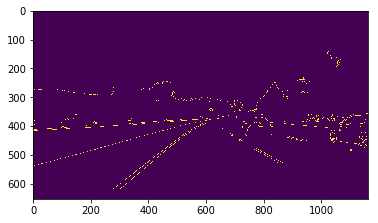

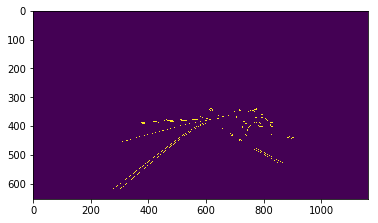

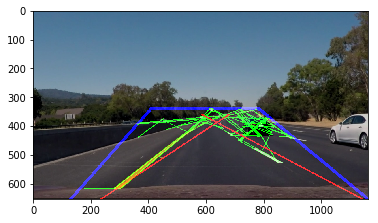

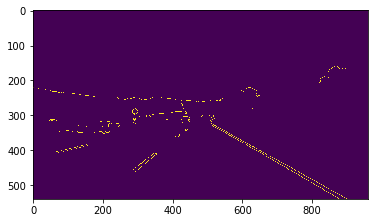

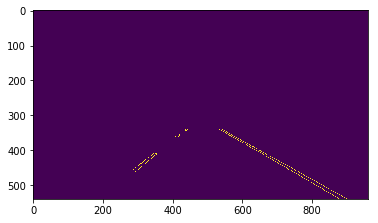

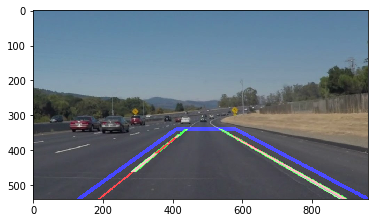

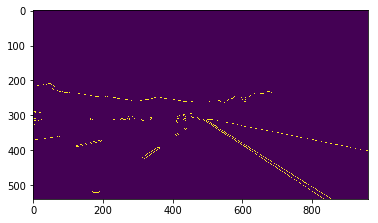

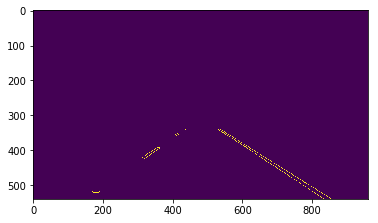

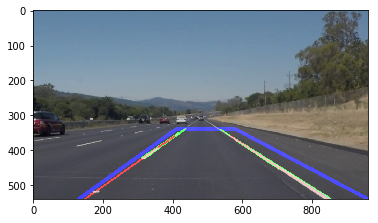

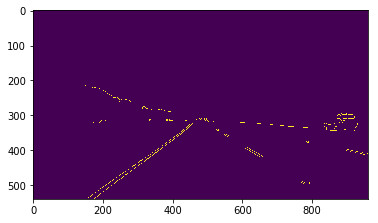

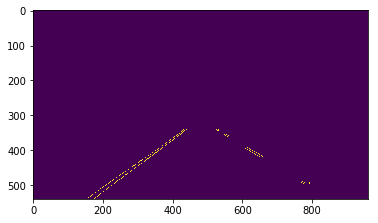

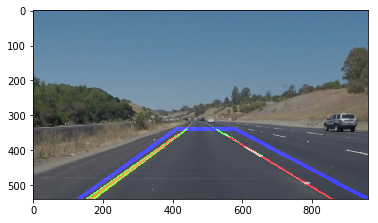

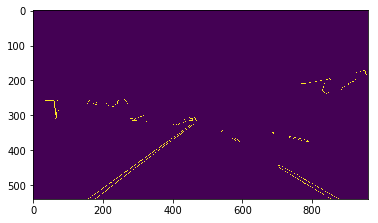

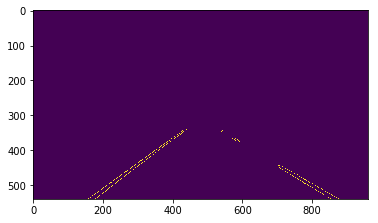

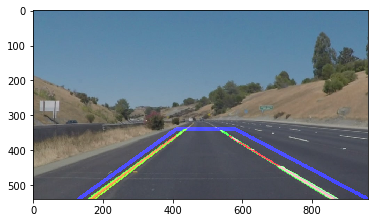

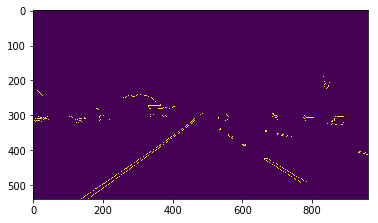

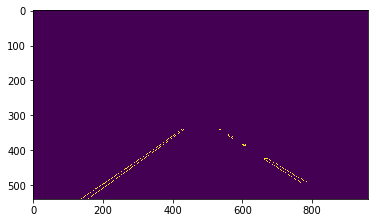

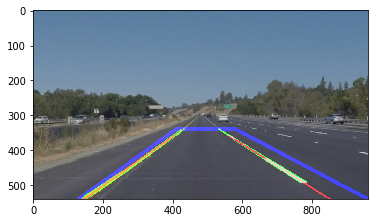

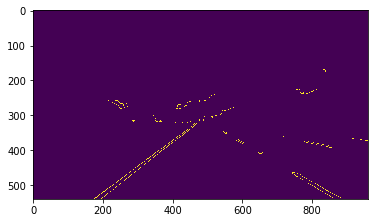

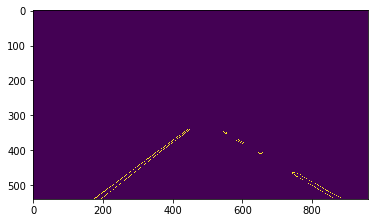

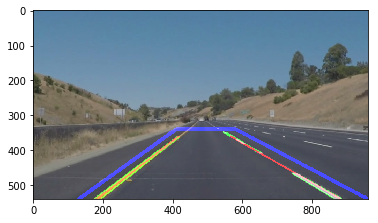

In [31]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images directory.

def load_image(s):
    return mpimg.imread(s)

def process_image(img):
    gray = grayscale(img)
    
    gaus_kernel = 7
    gaus = gaussian_blur(gray, gaus_kernel)
    
    canny_low = 80
    canny_high = 220
    canny_img = canny(gaus, canny_low, canny_high)
    plt.figure()
    plt.imshow(canny_img)
    
    imshape = img.shape
    #verticies_1 = np.array([[(100,imshape[0]),(420, 375), (375, 550), (imshape[1] - 75,imshape[0])]], dtype=np.int32)
    
    verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (130, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    reg_1 = region_of_interest(canny_img, verticies_1)
    verticies_2 = np.array([[(420,350),(420, 300), (550, 300), (550, 350)]], dtype=np.int32)
    reg_2 = region_of_interest(canny_img, verticies_2)
    plt.figure()
    plt.imshow(reg_1)
    rho = 1
    theta = np.pi/180
    threshold = 5
    min_line_length = 20
    max_line_gap = 75
    
    rho_2 = 1
    theta_2 = np.pi/180
    threshold_2 = 10
    min_line_length_2 = 1
    max_line_gap_2 = 30
    
    hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)
    ##hough_2 = hough_lines(reg_2, rho_2, theta_2, threshold_2, min_line_length_2, max_line_gap_2)
    
    
    img_with_hough = weighted_img(hough_1, img)
    ##return img_with_hough
    return img_with_hough

def process_images(imgs):
    for img_str in imgs:
        img = load_image('test_images/' + img_str)
        final_image = process_image(img)
        #printing out some stats and plotting
        print('This image is:', type(final_image), 'with dimensions:', final_image.shape)
        plt.figure()
        plt.imshow(final_image)

img_list = os.listdir('test_images/')
process_images(img_list)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an `import error` when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt. Also, check out [this forum post](https://carnd-forums.udacity.com/questions/22677062/answers/22677109) for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://carnd-forums.udacity.com/display/CAR/questions/26218840/import-videofileclip-error) for more troubleshooting tips across operating systems.**

In [32]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
def process_image(img):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    gray = grayscale(img)
    
    gaus_kernel = 7
    gaus = gaussian_blur(gray, gaus_kernel)
    
    canny_low = 80
    canny_high = 220
    canny_img = canny(gaus, canny_low, canny_high)
    #plt.figure()
    #plt.imshow(canny_img)
    
    imshape = img.shape
    verticies_1 = np.array([[(imshape[1] - 380, 340),(410, 340), (100, imshape[0]), (imshape[1],imshape[0])]], dtype=np.int32)
    reg_1 = region_of_interest(canny_img, verticies_1)
    verticies_2 = np.array([[(420,350),(420, 300), (550, 300), (550, 350)]], dtype=np.int32)
    reg_2 = region_of_interest(canny_img, verticies_2)
    
    rho = 1
    theta = np.pi/180
    threshold = 10
    min_line_length = 70
    max_line_gap = 150
    
    rho_2 = 1
    theta_2 = np.pi/180
    threshold_2 = 10
    min_line_length_2 = 1
    max_line_gap_2 = 20
    
    hough_1 = hough_lines(canny_img, rho, theta, threshold, min_line_length, max_line_gap)

    #hough_1 = hough_lines(reg_1, rho, theta, threshold, min_line_length, max_line_gap)
    ##hough_2 = hough_lines(reg_2, rho_2, theta_2, threshold_2, min_line_length_2, max_line_gap_2)
    
    
    result = weighted_img(hough_1, img)
    return result

Let's try the one with the solid white lane on the right first ...

In [34]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

<class 'numpy.ndarray'> (78, 1, 4)
818.235718865 540 549.196628943 360
-438.478863975 540 157.039917311 360
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  1%|▏         | 3/222 [00:00<00:07, 28.10it/s]

<class 'numpy.ndarray'> (78, 1, 4)
818.235718865 540 549.196628943 360
-438.478863975 540 157.039917311 360
<class 'numpy.ndarray'> (72, 1, 4)
868.538560219 540 582.85628795 360
-157.00600541 540 335.201880811 360
<class 'numpy.ndarray'> (53, 1, 4)
541.575592456 540 354.55311602 360
-720.533309303 540 116.109270234 360
<class 'numpy.ndarray'> (70, 1, 4)
475.310156918 540 315.472726827 360
52.6859167068 540 472.941920843 360
<class 'numpy.ndarray'> (71, 1, 4)
687.488709846 540 478.780710428 360
-1767.26213796 540 332.193792588 360
<class 'numpy.ndarray'> (72, 1, 4)
460.039709655 540 294.173369524 360
-1036.81344423 540 328.946931197 360
<class 'numpy.ndarray'>

  5%|▌         | 12/222 [00:00<00:06, 32.41it/s]

 (50, 1, 4)
492.429780264 540 335.515783244 360
-458.98097106 540 256.762982064 360
<class 'numpy.ndarray'> (55, 1, 4)
755.603591442 540 453.851578108 360
200.023380583 540 435.236467506 360
<class 'numpy.ndarray'> (44, 1, 4)
559.720874144 540 382.574459921 360
-942.612245307 540 54.293184032 360
<class 'numpy.ndarray'> (48, 1, 4)
558.834682143 540 409.736031022 360
-456.017518231 540 244.294045985 360
<class 'numpy.ndarray'> (61, 1, 4)
590.072116977 540 426.298802666 360
-1694.01897688 540 -119.831589301 360
<class 'numpy.ndarray'> (60, 1, 4)
793.049310629 540 481.084081993 360
-38.7727388286 540 326.720527756 360
<class 'numpy.ndarray'> (48, 1, 4)
968.061563596 540 538.270917214 360
-453.171853156 540 239.316842684 360
<class 'numpy.ndarray'> (39, 1, 4)
1080.52693302 540 577.519035105 360
-421.747614095 540 248.982682672 360
<class 'numpy.ndarray'> (41, 1, 4)
855.670906245 540 507.771612987 360
-192.658546166 540 308.099037191 360


  9%|▉         | 21/222 [00:00<00:05, 35.35it/s]

<class 'numpy.ndarray'> (44, 1, 4)
1095.5077839 540 565.110903979 360
-202.478165045 540 298.966806929 360
<class 'numpy.ndarray'> (48, 1, 4)
5949.64932299 540 1172.06563333 360
-2.651469633 540 4.36379506333 360
<class 'numpy.ndarray'> (52, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (47, 1, 4)
7168.65834975 540 1549.85482077 360
101.419006422 540 114.893592876 360
<class 'numpy.ndarray'> (46, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (42, 1, 4)
8534.79490852 540 1743.24667662 360
73.532589448 540 94.6297286327 360
<class 'numpy.ndarray'> (41, 1, 4)
1805.71191118 540 747.17526732 360
152.023629808 540 383.497503319 360
<class 'numpy.ndarray'> (41, 1, 4)
1304.76399645 540 587.105562097 360
-21.6689371942 540 348.974191216 360
<class 'numpy.ndarray'> (51, 1, 4)
-5737.59671058 540 -471.333408742 360
-9.90406180752 540 19.9842636956 360


 14%|█▎        | 30/222 [00:00<00:05, 36.42it/s]

<class 'numpy.ndarray'> (48, 1, 4)
1927.24887618 540 819.408733702 360
80.5628549798 540 254.011727366 360
<class 'numpy.ndarray'> (51, 1, 4)
1990.62050464 540 794.006837071 360
112.844160785 540 239.359612428 360
<class 'numpy.ndarray'> (46, 1, 4)
1446.04977038 540 661.334278157 360
137.945909266 540 310.125298931 360
<class 'numpy.ndarray'> (51, 1, 4)
-2115.20800524 540 -113.368782138 360
-14.4105375856 540 18.8444239484 360
<class 'numpy.ndarray'> (53, 1, 4)
4361.36317386 540 1321.07013696 360
130.625027981 540 219.27564656 360
<class 'numpy.ndarray'> (49, 1, 4)
3064.71856426 540 1030.7031409 360
160.70701362 540 290.546178055 360
<class 'numpy.ndarray'> (50, 1, 4)
-12140.2135349 540 -2704.0256099 360
30.5836818171 540 36.5067640136 360
<class 'numpy.ndarray'> (49, 1, 4)
1899.45129347 540 682.708307844 360
62.6181739285 540 90.5785892076

 15%|█▌        | 34/222 [00:00<00:05, 36.79it/s]

 360
<class 'numpy.ndarray'> (48, 1, 4)
12728.0473835 540 3109.67138878 360
7.32887484218 540 31.9706937605 360
<class 'numpy.ndarray'> (33, 1, 4)
-4990.81322634 540 -128.626751082 360
36.1661947014 540 44.1178654584 360
<class 'numpy.ndarray'> (42, 1, 4)
1058.75556527 540 550.820660936 360
-187.362908173 540 269.807407583 360
<class 'numpy.ndarray'> (41, 1, 4)
501.319416286 540 418.28983613 360
257.588903385 540 305.178191589 360
<class 'numpy.ndarray'> (52, 1, 4)
1333.4286732 540 584.261920494 360
145.016646389 540 324.895210825 360


 17%|█▋        | 38/222 [00:01<00:05, 34.45it/s]

<class 'numpy.ndarray'> (55, 1, 4)
550.975451119 540 459.993303803 360
-847.340216676 540 115.113195059 360


 19%|█▉        | 43/222 [00:01<00:05, 34.61it/s]

<class 'numpy.ndarray'> (70, 1, 4)
3390.93717806 540 1071.38334368 360
36.8389256648 540 46.8059542708 360
<class 'numpy.ndarray'> (61, 1, 4)
85.0147839208 540 78.0568468881 360
-2730.34719591 540 -85.1079144121 360
<class 'numpy.ndarray'> (66, 1, 4)
741.480738067 540 456.370820993 360
-467.465577815 540 251.209536059 360
<class 'numpy.ndarray'> (56, 1, 4)
2721.03318062 540 910.724410938 360
212.078044933 540 255.282276659 360
<class 'numpy.ndarray'> (59, 1, 4)
61.1324147595 540 54.070294255 360
-22.1525728052 540 307.067177175 360
<class 'numpy.ndarray'> (53, 1, 4)
821.663360488 540 502.70836903 360
-288.337511935 540 180.394240756 360
<class 'numpy.ndarray'>

 21%|██        | 47/222 [00:01<00:05, 30.69it/s]

 (49, 1, 4)
820.120489991 540 426.973898935 360
55.8765819564 540 302.944511028 360
<class 'numpy.ndarray'> (46, 1, 4)
823.072001504 540 528.165688878 360
-90.9505425624 540 313.254267013 360
<class 'numpy.ndarray'> (52, 1, 4)
1209.86369649 540 588.950759908 360
-305.993878342 540 269.823539882 360
<class 'numpy.ndarray'> (51, 1, 4)
2261.82724124 540 844.412897593 360
261.799603793 540 354.793721068 360
<class 'numpy.ndarray'> (52, 1, 4)
703.400443222 540 486.534211203 360
-326.694531106 540 181.013796988 360
<class 'numpy.ndarray'> (60, 1, 4)
2665.88353439 540 1031.85386672 360
151.985177884 540 261.777118462 360


 24%|██▍       | 54/222 [00:01<00:06, 25.31it/s]

<class 'numpy.ndarray'> (59, 1, 4)
2264.66605815 540 891.981525387 360
227.043318041 540 281.580483344 360
<class 'numpy.ndarray'> (66, 1, 4)
1510.69917988 540 708.871400874 360
93.9865815006 540 316.547238925 360
<class 'numpy.ndarray'> (56, 1, 4)
1747.23775601 540 791.191968781 360
216.955243943 540 304.508795459 360
<class 'numpy.ndarray'> (57, 1, 4)
1356.88895153 540 665.562489903 360
140.15776323 540 272.377020999 360
<class 'numpy.ndarray'> (59, 1, 4)
989.522009302 540 501.627400814 360
110.971265373 540 320.982892202 360


 27%|██▋       | 60/222 [00:01<00:07, 22.33it/s]

<class 'numpy.ndarray'> (56, 1, 4)
775.441409412 540 469.675635219 360
-219.124981763 540 226.716707665 360
<class 'numpy.ndarray'> (48, 1, 4)
665.900692941 540 394.047886023 360
-217.539122785 540 285.17787038 360
<class 'numpy.ndarray'> (59, 1, 4)
750.313645306 540 418.528270479 360
-461.865783617 540 170.087575749 360
<class 'numpy.ndarray'> (56, 1, 4)
1184.98479376 540 569.173258972 360
66.4558329205 540 331.956929759 360
<class 'numpy.ndarray'> (73, 1, 4)
985.949009006 540 496.97354804 360
-464.073766405 540 190.445633085 360


 28%|██▊       | 63/222 [00:02<00:07, 22.06it/s]

<class 'numpy.ndarray'> (61, 1, 4)
1104.03327422 540 513.760050612 360
-519.558455069 540 179.259321101 360
<class 'numpy.ndarray'> (59, 1, 4)
594.767810827 540 426.083792945 360
115.765444581 540 352.842887247 360
<class 'numpy.ndarray'> (57, 1, 4)
2428.63698509 540 974.066710953 360
183.982681471 540 291.173752173 360
<class 'numpy.ndarray'> (43, 1, 4)
1092.98522766 540 515.426664869 360
180.805107721 540 371.286148874 360
<class 'numpy.ndarray'> (43, 1, 4)
1 540 1 360
540.0 540 360.0 360


 31%|███       | 69/222 [00:02<00:06, 23.17it/s]

<class 'numpy.ndarray'> (44, 1, 4)
509.99695019 540 429.338137626 360
426.133547055 540 474.093645883 360
<class 'numpy.ndarray'> (55, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (58, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (50, 1, 4)
273.933749542 540 235.03140035 360
-40.8289009505 540 267.318022016 360
<class 'numpy.ndarray'> (49, 1, 4)
1234.37918809 540 590.889227289 360
-318.520918236 540 239.623223876 360


 34%|███▍      | 75/222 [00:02<00:06, 22.37it/s]

<class 'numpy.ndarray'> (60, 1, 4)
590.370966733 540 519.467863953 360
-890.400362929 540 28.8468983126 360
<class 'numpy.ndarray'> (63, 1, 4)
912.827215508 540 571.849057466 360
331.664382466 540 415.552271568 360
<class 'numpy.ndarray'> (57, 1, 4)
640.115825858 540 501.703745218 360
-459.223527463 540 197.082985737 360
<class 'numpy.ndarray'> (54, 1, 4)
110.345588235 540 103.538865546 360
-1204.47377332 540 191.185289629 360
<class 'numpy.ndarray'> (65, 1, 4)
711.577553624 540 568.234378936 360
-543.200794976 540 199.286389935 360


 35%|███▌      | 78/222 [00:02<00:06, 22.70it/s]

<class 'numpy.ndarray'> (47, 1, 4)
1104.20853482 540 520.435334041 360
-60.3108488824 540 352.981991079 360
<class 'numpy.ndarray'> (62, 1, 4)
659.665741081 540 449.60233275 360
-331.063171376 540 249.491083776 360
<class 'numpy.ndarray'> (34, 1, 4)
1207.67226489 540 552.447418998 360
-25.2511899405 540 364.466770902 360
<class 'numpy.ndarray'> (59, 1, 4)
797.702988429 540 504.240749283 360
-611.066457739 540 143.577269294 360
<class 'numpy.ndarray'> (32, 1, 4)
986.588873941 540 500.870657824 360
75.4575806561 540 379.808929591 360


 38%|███▊      | 84/222 [00:03<00:06, 21.90it/s]

<class 'numpy.ndarray'> (36, 1, 4)
718.056874497 540 496.611887107 360
-540.697035172 540 237.846022158 360
<class 'numpy.ndarray'> (57, 1, 4)
851.715688613 540 502.613277518 360
383.673216911 540 518.808912163 360
<class 'numpy.ndarray'> (36, 1, 4)
200992.326693 540 50533.5562879 360
138.346153846 540 143.538461538 360
<class 'numpy.ndarray'> (53, 1, 4)
607.652621758 540 380.203405547 360
-719.023140301 540 119.39728908 360
<class 'numpy.ndarray'> (49, 1, 4)
1189.44241474 540 606.11995235 360
-192.803280564 540 301.252326117 360


 41%|████      | 90/222 [00:03<00:06, 21.94it/s]

<class 'numpy.ndarray'> (51, 1, 4)
966.544098612 540 540.320950142 360
-363.154473878 540 261.156526099 360
<class 'numpy.ndarray'> (50, 1, 4)
813.472795969 540 497.029891121 360
-350.424304373 540 277.317029963 360
<class 'numpy.ndarray'> (52, 1, 4)
500.282737654 540 400.610152208 360
-328.850018076 540 279.925428111 360
<class 'numpy.ndarray'> (60, 1, 4)
631.877081196 540 622.904624198 360
-2211.4290694 540 -250.701882175 360
<class 'numpy.ndarray'> (64, 1, 4)
722.120745127 540 488.540492938 360
-187.665500468 540 293.943725947 360


 42%|████▏     | 93/222 [00:03<00:06, 20.79it/s]

<class 'numpy.ndarray'> (63, 1, 4)
554.69805775 540 418.270017524 360
-761.412718863 540 128.907529773 360
<class 'numpy.ndarray'> (60, 1, 4)
786.857539528 540 466.523708171 360
-223.449845234 540 320.784389174 360
<class 'numpy.ndarray'> (71, 1, 4)
566.625639978 540 475.120419426 360
-573.135223677 540 166.677474091 360
<class 'numpy.ndarray'> (51, 1, 4)
617.213192592 540 422.464312652 360
244.25213774 540 442.561704438 360
<class 'numpy.ndarray'> (64, 1, 4)
1197.93207596 540 591.349387093 360
77.5733409058 540 388.643048693 360


 45%|████▍     | 99/222 [00:03<00:05, 22.52it/s]

<class 'numpy.ndarray'> (62, 1, 4)
780.601970722 540 534.558681768 360
-319.025063123 540 238.672304207 360
<class 'numpy.ndarray'> (64, 1, 4)
560.834968264 540 477.401157669 360
-492.360154774 540 221.829583007 360
<class 'numpy.ndarray'> (70, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (60, 1, 4)
759.7913326 540 591.306104013 360
-772.732638871 540 57.3795828065 360
<class 'numpy.ndarray'> (59, 1, 4)
12686.3224105 540 3402.49039106 360
762.312730627 540 766.962177122 360


 47%|████▋     | 105/222 [00:04<00:05, 21.82it/s]

<class 'numpy.ndarray'> (56, 1, 4)
305.194030663 540 281.691015354 360
-2708.82052987 540 -222.166465154 360
<class 'numpy.ndarray'> (63, 1, 4)
993.033546902 540 499.803382181 360
261.344723694 540 387.650094723 360
<class 'numpy.ndarray'> (60, 1, 4)
2656.89847345 540 1029.08030016 360
300.189777818 540 365.003148449 360
<class 'numpy.ndarray'> (58, 1, 4)
278.74976974 540 262.83421295 360
-10777.6458681 540 -2367.91846793 360
<class 'numpy.ndarray'> (59, 1, 4)
1081.17024314 540 532.48004308 360
-177.827396014 540 296.144733596 360


 49%|████▊     | 108/222 [00:04<00:05, 20.61it/s]

<class 'numpy.ndarray'> (57, 1, 4)
1491.38051646 540 680.383493524 360
-128.083564673 540 293.441273455 360
<class 'numpy.ndarray'> (53, 1, 4)
1129.1487567 540 591.002822659 360
641.074733096 540 644.918149466 360
<class 'numpy.ndarray'> (46, 1, 4)
1177.2686191 540 587.441767865 360
-3.19233080387 540 353.229515757 360
<class 'numpy.ndarray'> (50, 1, 4)
-4485.52291621 540 -445.177462039 360
646.642169448 540 649.414955071 360


 51%|█████▏    | 114/222 [00:04<00:04, 21.66it/s]

<class 'numpy.ndarray'> (62, 1, 4)
579.437102147 540 563.899151339 360
91.4661270905 540 382.275017233 360
<class 'numpy.ndarray'> (63, 1, 4)
2105.9443362 540 857.468218572 360
50.5361286715 540 311.452253752 360
<class 'numpy.ndarray'> (68, 1, 4)
-3149.90793353 540 -330.028848871 360
470.993287968 540 476.538601918 360
<class 'numpy.ndarray'> (63, 1, 4)
2018.26687428 540 789.105766242 360
94.9071576936 540 413.496796924 360
<class 'numpy.ndarray'> (63, 1, 4)
642.909774436 540 640.203007519 360
-1030.42524516 540 192.289244443 360


 53%|█████▎    | 117/222 [00:04<00:04, 21.67it/s]

<class 'numpy.ndarray'> (76, 1, 4)
1492.21770599 540 655.079574341 360
-164.730117296 540 296.985981323 360
<class 'numpy.ndarray'> (79, 1, 4)
1861.68193223 540 742.670090987 360
-11.9188651117 540 355.244265851 360
<class 'numpy.ndarray'> (63, 1, 4)
2091.10165158 540 684.955403665 360
286.406460108 540 323.435552998 360
<class 'numpy.ndarray'> (55, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (48, 1, 4)
1 540 1 360
540.0 540 360.0 360


 55%|█████▍    | 122/222 [00:04<00:05, 19.28it/s]

<class 'numpy.ndarray'> (49, 1, 4)
1128.78866688 540 612.540185432 360
-617.975191822 540 176.119474645 360
<class 'numpy.ndarray'> (76, 1, 4)
930.117171212 540 554.543622937 360
-0.923455893305 540 303.515820503 360
<class 'numpy.ndarray'> (64, 1, 4)
2033.33555351 540 737.955172295 360
84.550484773 540 346.795239991 360
<class 'numpy.ndarray'> (81, 1, 4)
1 540 1 360
540.0 540 360.0 360


 57%|█████▋    | 126/222 [00:05<00:05, 18.87it/s]

<class 'numpy.ndarray'> (80, 1, 4)
-2301.09302282 540 -190.578363669 360
286.173395278 540 305.03733356 360
<class 'numpy.ndarray'> (57, 1, 4)
849.354364699 540 516.142135972 360
815.34568141 540 825.033980725 360
<class 'numpy.ndarray'> (76, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (49, 1, 4)
2378.4257732 540 670.639831801 360
-41.10729566 540 292.424318778 360
<class 'numpy.ndarray'> (62, 1, 4)
5100.43071096 540 1250.79437597 360
171.494641001 540 186.492444119 360


 58%|█████▊    | 129/222 [00:05<00:04, 19.54it/s]

<class 'numpy.ndarray'> (75, 1, 4)
2698.74100813 540 909.189343797 360
-208.93755404 540 315.259084556 360
<class 'numpy.ndarray'> (52, 1, 4)
2081.94834972 540 906.615181024 360
-310.558718812 540 248.962997704 360
<class 'numpy.ndarray'> (50, 1, 4)
787.764619663 540 531.331927848 360
269.859484718 540 448.492936875 360
<class 'numpy.ndarray'> (37, 1, 4)
1026.33490105 540 435.658872558 360
-123.322999013 540 266.247869096 360


 61%|██████    | 135/222 [00:05<00:04, 20.41it/s]

<class 'numpy.ndarray'> (48, 1, 4)
614.311748809 540 592.959049447 360
196.694116564 540 339.384840096 360
<class 'numpy.ndarray'> (60, 1, 4)
1230.94205529 540 686.805629687 360
-410.408129852 540 225.35013743 360
<class 'numpy.ndarray'> (42, 1, 4)
2436.56901994 540 588.898107793 360
248.386084192 540 478.268799041 360
<class 'numpy.ndarray'> (60, 1, 4)
1223.87651303 540 578.236042631 360
51.4397397456 540 353.221100813 360
<class 'numpy.ndarray'> (42, 1, 4)
3471.72298697 540 977.741723665 360
322.425127118 540 417.323326172 360


 63%|██████▎   | 140/222 [00:05<00:04, 18.20it/s]

<class 'numpy.ndarray'> (38, 1, 4)
664.665852617 540 647.737073345 360
-662.330619465 540 207.795192332 360
<class 'numpy.ndarray'> (42, 1, 4)
1990.08714866 540 696.560632365 360
336.052052657 540 435.517948783 360
<class 'numpy.ndarray'> (48, 1, 4)
1597.28088297 540 533.843602665 360
-162.270880491 540 276.158211799 360
<class 'numpy.ndarray'> (54, 1, 4)
1751.4463463 540 696.450303593 360
-287.830211543 540 229.779343948 360


 65%|██████▍   | 144/222 [00:06<00:04, 18.41it/s]

<class 'numpy.ndarray'> (58, 1, 4)
2380.16266287 540 904.004596138 360
-153.638369972 540 234.053367404 360
<class 'numpy.ndarray'> (41, 1, 4)
1349.03220532 540 584.069528945 360
-237.523510481 540 240.782210668 360
<class 'numpy.ndarray'> (47, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (51, 1, 4)
5100.53362404 540 981.112729605 360
257.613908005 540 390.829376197 360


 66%|██████▌   | 147/222 [00:06<00:04, 18.62it/s]

<class 'numpy.ndarray'> (46, 1, 4)
1552.91760794 540 594.203487074 360
-291.815991307 540 238.264398651 360
<class 'numpy.ndarray'> (51, 1, 4)
2190.80406821 540 671.244398198 360
30.4799764954 540 294.530986072 360
<class 'numpy.ndarray'> (61, 1, 4)
1366.39108811 540 527.749014262 360
-207.820352511 540 290.810203791 360
<class 'numpy.ndarray'> (49, 1, 4)
1133.59942778 540 499.830404731 360
-54.049860474 540 288.858236961 360
<class 'numpy.ndarray'> (53, 1, 4)
1109.38141044 540 562.294282915 360
-153.362147069 540 248.683022575 360


 69%|██████▉   | 154/222 [00:06<00:03, 18.67it/s]

<class 'numpy.ndarray'> (51, 1, 4)
851.814956197 540 529.470760051 360
-447.85276053 540 196.756921404 360
<class 'numpy.ndarray'> (52, 1, 4)
863.129361738 540 484.94050393 360
-334.523903642 540 220.358780827 360
<class 'numpy.ndarray'> (52, 1, 4)
1570.40828916 540 547.490998716 360
-193.279159027 540 282.766104404 360
<class 'numpy.ndarray'> (67, 1, 4)
804.16051616 540 479.753287302 360
-247.890941282 540 246.335687489 360


 70%|███████   | 156/222 [00:06<00:03, 18.86it/s]

<class 'numpy.ndarray'> (76, 1, 4)
1721.04476596 540 718.540083173 360
-454.999410193 540 165.258995849 360
<class 'numpy.ndarray'> (64, 1, 4)
1159.21242265 540 580.22939911 360
-464.199269956 540 178.700266056 360
<class 'numpy.ndarray'> (73, 1, 4)
970.209475564 540 583.614895419 360
-565.235183054 540 167.844085169 360
<class 'numpy.ndarray'> (63, 1, 4)
2066.64749305 540 598.077151768 360
110.625628564 540 383.712611147 360
<class 'numpy.ndarray'> (60, 1, 4)
1609.71287846 540 639.238639582 360
9.93489063206 540 342.316872334 360


 73%|███████▎  | 162/222 [00:06<00:03, 19.39it/s]

<class 'numpy.ndarray'> (65, 1, 4)
922.559703378 540 397.102750808 360
-123.201101226 540 280.291309491 360
<class 'numpy.ndarray'> (70, 1, 4)
1236.68242296 540 513.988866711 360
-127.44026869 540 298.443986334 360
<class 'numpy.ndarray'> (67, 1, 4)
1067.9377055 540 509.127165222 360
-383.529736046 540 202.26979588 360
<class 'numpy.ndarray'> (74, 1, 4)
1322.16661976 540 508.962001971 360
-359.076180001 540 204.960031207 360


 75%|███████▍  | 166/222 [00:07<00:03, 18.30it/s]

<class 'numpy.ndarray'> (64, 1, 4)
1301.11448344 540 518.795692963 360
-258.7571606 540 239.552968588 360
<class 'numpy.ndarray'> (67, 1, 4)
2066.10571631 540 790.270797884 360
-136.965569757 540 301.915988938 360
<class 'numpy.ndarray'> (79, 1, 4)
12770.159056 540 3328.86122366 360
293.840658978 540 452.456823268 360
<class 'numpy.ndarray'> (70, 1, 4)
1878.64640667 540 726.832515971 360
-304.304873758 540 232.403122762 360


 76%|███████▌  | 168/222 [00:07<00:03, 15.56it/s]

<class 'numpy.ndarray'> (61, 1, 4)
2004.24361916 540 665.854753379 360
-219.946665322 540 256.994360922 360
<class 'numpy.ndarray'> (61, 1, 4)
3310.13524135 540 1022.01259673 360
-200.666330198 540 283.247496899 360
<class 'numpy.ndarray'> (62, 1, 4)
864.662408442 540 452.637515442 360
-478.525428061 540 195.726129086 360
<class 'numpy.ndarray'> (67, 1, 4)
2098.53165193 540 673.707512952 360
-193.508103674 540 292.618454411 360


 79%|███████▉  | 176/222 [00:07<00:02, 18.49it/s]

<class 'numpy.ndarray'> (69, 1, 4)
2176.88577025 540 671.950669418 360
11.5990316372 540 354.413073859 360
<class 'numpy.ndarray'> (71, 1, 4)
1899.47898387 540 577.010878932 360
-183.316812292 540 262.791121948 360
<class 'numpy.ndarray'> (63, 1, 4)
2631.7921715 540 823.514474712 360
61.5543774433 540 356.621869701 360
<class 'numpy.ndarray'> (72, 1, 4)
1680.45566479 540 583.128423826 360
-343.679942098 540 219.914929828 360
<class 'numpy.ndarray'> (76, 1, 4)
962.43759734 540 470.401369276 360
-118.680323558 540 259.803470758 360


 81%|████████  | 179/222 [00:07<00:02, 18.30it/s]

<class 'numpy.ndarray'> (70, 1, 4)
1188.27412032 540 522.527760959 360
-254.808471567 540 218.64224933 360
<class 'numpy.ndarray'> (69, 1, 4)
1915.39231497 540 735.141415583 360
-189.971673204 540 246.069474028 360
<class 'numpy.ndarray'> (60, 1, 4)
967.761876846 540 536.163051957 360
-704.418339784 540 110.027903552 360
<class 'numpy.ndarray'> (54, 1, 4)
2060.1434127 540 743.096833595 360
-153.925693039 540 311.834106467 360


 82%|████████▏ | 183/222 [00:08<00:02, 17.45it/s]

<class 'numpy.ndarray'> (67, 1, 4)
8475.2291939 540 2231.49119035 360
16.6027117917 540 307.524858478 360
<class 'numpy.ndarray'> (71, 1, 4)
576.469131037 540 473.747753648 360
-564.127643473 540 116.886029269 360
<class 'numpy.ndarray'> (63, 1, 4)
1207.62899289 540 508.431554198 360
-110.649660977 540 309.400450641 360
<class 'numpy.ndarray'> (78, 1, 4)
1169.52496841 540 496.730882765 360
-152.091178991 540 301.035669136 360


 85%|████████▍ | 188/222 [00:08<00:01, 18.16it/s]

<class 'numpy.ndarray'> (78, 1, 4)
1273.16939913 540 522.480782501 360
-284.101899482 540 268.705453223 360
<class 'numpy.ndarray'> (75, 1, 4)
1179.14205477 540 478.817963468 360
-393.620276982 540 183.307876365 360
<class 'numpy.ndarray'> (84, 1, 4)
1240.05054163 540 584.459553125 360
-416.437842512 540 196.923916909 360
<class 'numpy.ndarray'> (82, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (65, 1, 4)
829.330410426 540 490.548315272 360
-355.144351984 540 203.516442417 360


 87%|████████▋ | 193/222 [00:08<00:01, 19.69it/s]

<class 'numpy.ndarray'> (60, 1, 4)
1166.18966703 540 524.086829164 360
-311.609807045 540 206.469221626 360
<class 'numpy.ndarray'> (76, 1, 4)
2206.12114978 540 749.979069069 360
-42.8496699874 540 338.757693469 360
<class 'numpy.ndarray'> (75, 1, 4)
1228.49356181 540 568.991497491 360
-308.562366125 540 235.529387499 360
<class 'numpy.ndarray'> (94, 1, 4)
1795.05076236 540 693.700801196 360
107.743199575 540 369.344822636 360
<class 'numpy.ndarray'> (75, 1, 4)
1134.50048027 540 510.904696833 360
-352.315509204 540 229.335785065 360
<class 'numpy.ndarray'>

 88%|████████▊ | 196/222 [00:08<00:01, 20.25it/s]

 (72, 1, 4)
1882.5671512 540 728.55445334 360
-165.13230482 540 307.797335916 360
<class 'numpy.ndarray'> (68, 1, 4)
1099.04497122 540 493.853953917 360
-227.845625455 540 279.87937358 360
<class 'numpy.ndarray'> (70, 1, 4)
1477.56705704 540 606.887417566 360
-247.279982299 540 276.833664573 360
<class 'numpy.ndarray'> (60, 1, 4)
2627.59219908 540 886.504888177 360
-239.061815733 540 265.797628422 360
<class 'numpy.ndarray'> (77, 1, 4)
1360.73091781 540 579.421492133 360
-321.65810877 540 244.123405869 360


 91%|█████████ | 202/222 [00:09<00:00, 21.22it/s]

<class 'numpy.ndarray'> (67, 1, 4)
637.724416929 540 551.607278793 360
-822.116551054 540 58.376190579 360
<class 'numpy.ndarray'> (74, 1, 4)
1763.25369791 540 627.75972627 360
-139.276116304 540 319.316249035 360
<class 'numpy.ndarray'> (68, 1, 4)
651.021893513 540 484.018751082 360
-472.423199494 540 162.030257159 360
<class 'numpy.ndarray'> (70, 1, 4)
1971.17781386 540 785.758159542 360
23.9791229339 540 331.234792011 360
<class 'numpy.ndarray'> (67, 1, 4)
1073.00514917 540 468.532598111 360
-330.440360216 540 228.862448263 360


 94%|█████████▎| 208/222 [00:09<00:00, 21.54it/s]

<class 'numpy.ndarray'> (68, 1, 4)
2790.56404031 540 744.00456423 360
242.968425859 540 396.795450904 360
<class 'numpy.ndarray'> (76, 1, 4)
5742.22397098 540 1776.7203952 360
298.238084194 540 435.030260617 360
<class 'numpy.ndarray'> (54, 1, 4)
3485.54123709 540 889.604093311 360
46.284238869 540 340.997694642 360
<class 'numpy.ndarray'> (79, 1, 4)
2545.0388381 540 892.173110752 360
-206.492991408 540 275.702675155 360
<class 'numpy.ndarray'> 

 95%|█████████▌| 211/222 [00:09<00:00, 19.47it/s]

(65, 1, 4)
1510.29881896 540 643.21069857 360
-89.3865995891 540 322.032817686 360
<class 'numpy.ndarray'> (59, 1, 4)
2169.29096244 540 772.095945442 360
-188.290692017 540 265.977579361 360
<class 'numpy.ndarray'> (67, 1, 4)
2445.98245018 540 861.286459101 360
-106.981906422 540 304.476685426 360
<class 'numpy.ndarray'> (75, 1, 4)
1643.12504801 540 589.096210963 360
-211.709864477 540 282.723969935 360


 97%|█████████▋| 216/222 [00:09<00:00, 18.41it/s]

<class 'numpy.ndarray'> (61, 1, 4)
873.900308138 540 441.852716337 360
-191.120318919 540 261.533928362 360
<class 'numpy.ndarray'> (59, 1, 4)
2785.54977577 540 902.644224911 360
-136.642578364 540 308.734132838 360
<class 'numpy.ndarray'> (54, 1, 4)
3052.72257641 540 866.384110045 360
-61.413598233 540 296.113941827 360
<class 'numpy.ndarray'> (55, 1, 4)
292.478672986 540 289.066350711 360
-759.557601692 540 168.707799716 360
<class 'numpy.ndarray'> (72, 1, 4)
-11760.2344916 540 -2730.14784763 360
-140.906428911 540 239.782206874 360


100%|█████████▉| 221/222 [00:10<00:00, 19.10it/s]

<class 'numpy.ndarray'> (64, 1, 4)
3152.39274104 540 1013.17776765 360
25.3550353676 540 322.627899312 360
<class 'numpy.ndarray'> (51, 1, 4)
1775.17056145 540 712.681000749 360
-17.0033686508 540 329.580705225 360
<class 'numpy.ndarray'> (51, 1, 4)
1282.36196334 540 568.834409236 360
-169.138247876 540 275.506679768 360
<class 'numpy.ndarray'> (60, 1, 4)
35786.2269795 540 9414.34506045 360
290.422905963 540 410.641410364 360


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 6.24 s, sys: 660 ms, total: 6.9 s
Wall time: 11.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [35]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [36]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

<class 'numpy.ndarray'> (78, 1, 4)
1747.34609498 540 805.455849574 360
-454.480696865 540 201.159877457 360
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:19, 33.95it/s]

<class 'numpy.ndarray'> (78, 1, 4)
1747.34609498 540 805.455849574 360
-454.480696865 540 201.159877457 360
<class 'numpy.ndarray'> (81, 1, 4)
1661.74765272 540 756.462467663 360
-462.242291583 540 166.134291492 360
<class 'numpy.ndarray'> (81, 1, 4)
1147.78514641 540 657.790186483 360
-1289.38026779 540 -30.1119820215 360
<class 'numpy.ndarray'> (89, 1, 4)
1178.32213247 540 626.380928009 360
-1274.20729007 540 25.4748838542 360
<class 'numpy.ndarray'> (80, 1, 4)
1033.58761817 540 625.542752775 360
-1928.55341654 540 -130.770163702 360
<class 'numpy.ndarray'> (81, 1, 4)
1271.53224444 540 684.543935348 360
-2018.7843323 540 -156.642048873 360
<class 'numpy.ndarray'> (70, 1, 4)
1394.48905246 540 725.280987913 360
-1024.3179831 540 55.4479634663 360


  2%|▏         | 12/682 [00:00<00:19, 34.13it/s]

<class 'numpy.ndarray'> (91, 1, 4)
1683.82848279 540 781.124406844 360
-797.313461462 540 128.603089307 360
<class 'numpy.ndarray'> (80, 1, 4)
1574.4723269 540 715.899646396 360
-464.348008949 540 225.741773793 360
<class 'numpy.ndarray'> (68, 1, 4)
1120.44699218 540 631.086553691 360
-866.659984517 540 170.949646441 360
<class 'numpy.ndarray'> (60, 1, 4)
1914.12122925 540 836.171701652 360
-327.263624107 540 204.899273688 360
<class 'numpy.ndarray'> (69, 1, 4)
1258.48753589 540 704.509469664 360
-1135.86783538 540 18.116800275 360
<class 'numpy.ndarray'> (71, 1, 4)
1476.31218693 540 741.228466064 360
-261.997710063 540 279.022561071 360
<class 'numpy.ndarray'> (59, 1, 4)
1144.68213402 540 655.539791975 360
-462.635143376 540 202.626801391 360
<class 'numpy.ndarray'> (66, 1, 4)
992.616794199 540

  3%|▎         | 20/682 [00:00<00:18, 35.65it/s]

 618.588133977 360
-1095.42589872 540 14.4905540381 360
<class 'numpy.ndarray'> (70, 1, 4)
1055.92695305 540 652.507752935 360
-107.333123802 540 331.784324233 360
<class 'numpy.ndarray'> (71, 1, 4)
1379.05926568 540 681.537152047 360
-461.935041327 540 227.146156432 360
<class 'numpy.ndarray'> (70, 1, 4)
1317.4444329 540 702.63259783 360
-398.265127178 540 263.753889852 360
<class 'numpy.ndarray'> (75, 1, 4)
1338.61993393 540 695.543679037 360
-393.371027365 540 282.212609074 360
<class 'numpy.ndarray'> (78, 1, 4)
1320.96308322 540 695.186009736 360
-753.748498753 540 157.841683299 360
<class 'numpy.ndarray'> (83, 1, 4)
1279.66361772 540 642.808514075 360
-476.334852344 540 146.397406652 360
<class 'numpy.ndarray'> (73, 1, 4)
1277.91035659 540 671.847412705 360
-807.017097543 540 124.89268198 360


  4%|▎         | 24/682 [00:00<00:18, 35.32it/s]

<class 'numpy.ndarray'> (75, 1, 4)
1239.96331989 540 680.132891441 360
-378.055533389 540 237.046183648 360
<class 'numpy.ndarray'> (71, 1, 4)
1500.92188548 540 703.889780234 360
-301.295166638 540 258.451824707 360
<class 'numpy.ndarray'> (72, 1, 4)
981.601114961 540 616.952790894 360
-871.759254057 540 97.2775400054 360
<class 'numpy.ndarray'> (75, 1, 4)
1029.74539794 540 625.424733431 360
-839.626482442 540 121.310338536 360
<class 'numpy.ndarray'> (75, 1, 4)
1779.9346203 540 752.470024632 360
-109.384533517 540 305.547445133 360


  4%|▍         | 28/682 [00:00<00:19, 33.48it/s]

<class 'numpy.ndarray'> (74, 1, 4)
1303.54644387 540 616.039834358 360
-143.88780358 540 316.927231919 360
<class 'numpy.ndarray'> (83, 1, 4)
1170.80405524 540 635.921204349 360
-428.165736468 540 216.159711677 360


  5%|▍         | 32/682 [00:00<00:18, 34.66it/s]

<class 'numpy.ndarray'> (76, 1, 4)
958.048439909 540 609.900089547 360
-1067.88914507 540 -5.33715231416 360
<class 'numpy.ndarray'> (79, 1, 4)
1452.50076757 540 667.386989967 360
-128.860716575 540 336.336492381 360
<class 'numpy.ndarray'> (63, 1, 4)
1376.45257612 540 715.825064968 360
-237.374786076 540 240.778596193 360
<class 'numpy.ndarray'> (79, 1, 4)
1712.73976987 540 805.06956532 360
-38.8626607773 540 243.359245236 360
<class 'numpy.ndarray'> (62, 1, 4)
1123.44768937 540 609.455808606 360
-311.285099945 540 252.33871638 360
<class 'numpy.ndarray'> (65, 1, 4)
2185.82202934 540 870.626744656 360
298.184918528 540 406.935484129 360


  5%|▌         | 36/682 [00:01<00:18, 34.73it/s]

<class 'numpy.ndarray'> (56, 1, 4)
1564.18264718 540 712.503944562 360
202.613025642 540 442.687199792 360
<class 'numpy.ndarray'> (69, 1, 4)
1631.15245704 540 738.547103559 360
-172.538604479 540 285.656028188 360


  6%|▌         | 40/682 [00:01<00:18, 34.51it/s]

<class 'numpy.ndarray'> (61, 1, 4)
1568.41303668 540 679.923719287 360
44.6230180715 540 391.626537247 360
<class 'numpy.ndarray'> (67, 1, 4)
1106.97140446 540 617.496150767 360
-390.863899584 540 211.835461815 360
<class 'numpy.ndarray'> (76, 1, 4)
1381.10263204 540 680.590721027 360
-88.370766758 540 319.877757255 360
<class 'numpy.ndarray'> (65, 1, 4)
1426.65534893 540 698.328346507 360
-126.197629163 540 276.193168583 360
<class 'numpy.ndarray'> (72, 1, 4)
1057.82301605 540 565.6194519 360
-975.156077048 540 64.2382217724 360
<class 'numpy.ndarray'> (64, 1, 4)
1062.21954109 540 629.125002972 360
-687.165596287 540 148.988618153 360


  6%|▋         | 44/682 [00:01<00:20, 31.79it/s]

<class 'numpy.ndarray'> (76, 1, 4)
1492.70077778 540 746.691386745 360
-387.79760812 540 217.805878741 360
<class 'numpy.ndarray'> (77, 1, 4)
1585.17080029 540 771.741578754 360
-189.201473163 540 284.398477577 360
<class 'numpy.ndarray'> (79, 1, 4)
1269.87935053 540 666.065562217 360
-386.205264153 540 222.279483938 360
<class 'numpy.ndarray'> (71, 1, 4)
1922.54635198 540 783.677342792 360
-211.321430751 540 260.945703786 360
<class 'numpy.ndarray'> (70, 1, 4)
1593.05860403 540 718.629201393 360
-100.801220865 540 308.118957287 360


  7%|▋         | 48/682 [00:01<00:21, 29.83it/s]

<class 'numpy.ndarray'> (64, 1, 4)
780.126712162 540 609.093100196 360
-173.350844667 540 269.008618067 360


  7%|▋         | 51/682 [00:01<00:25, 24.59it/s]

<class 'numpy.ndarray'> (75, 1, 4)
1695.87533451 540 739.518283005 360
34.6229342208 540 326.66950377 360
<class 'numpy.ndarray'> (71, 1, 4)
1548.56381731 540 725.741404533 360
-241.553849954 540 280.466670482 360
<class 'numpy.ndarray'> (67, 1, 4)
1116.80442355 540 628.220255169 360
-1489.61966811 540 -85.3056744693 360
<class 'numpy.ndarray'> (73, 1, 4)
1880.44956325 540 801.268654066 360
74.2480402035 540 355.847796716 360
<class 'numpy.ndarray'> (72, 1, 4)
1067.42497743 540 644.855150191 360
-802.978581093 540 157.376941728 360


  8%|▊         | 54/682 [00:01<00:27, 23.06it/s]

<class 'numpy.ndarray'> (78, 1, 4)
1007.30238918 540 581.341179486 360
-987.863996628 540 116.609734321 360
<class 'numpy.ndarray'> (62, 1, 4)
1277.29791895 540 726.591735074 360
-403.984051436 540 173.150072654 360


  8%|▊         | 57/682 [00:01<00:28, 21.57it/s]

<class 'numpy.ndarray'> (70, 1, 4)
1636.83507858 540 789.155388353 360
-267.026272197 540 241.64600834 360
<class 'numpy.ndarray'> (74, 1, 4)
765.016453263 540 682.755863189 360
-3369.35175263 540 -548.587915463 360


  9%|▉         | 60/682 [00:02<00:31, 19.67it/s]

<class 'numpy.ndarray'> (79, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (67, 1, 4)
996.622844461 540 708.014074154 360
-2333.40880087 540 -286.91236855 360
<class 'numpy.ndarray'> (72, 1, 4)
1547.74319915 540 770.024530375 360
-234.790805967 540 295.931790498 360
<class 'numpy.ndarray'> (66, 1, 4)
1027.84904521 540 708.769220947 360
-1633.28629626 540 -88.4693660338 360


  9%|▉         | 63/682 [00:02<00:31, 19.79it/s]

<class 'numpy.ndarray'> (68, 1, 4)
910.52951252 540 682.892994722 360
-1230.93405799 540 80.4679952922 360
<class 'numpy.ndarray'> (65, 1, 4)
1393.32001374 540 668.69276516 360
-541.236907935 540 266.551542402 360


 10%|▉         | 66/682 [00:02<00:31, 19.82it/s]

<class 'numpy.ndarray'> (71, 1, 4)
632.550914043 540 563.604003453 360
-2201.9278795 540 -144.581500721 360
<class 'numpy.ndarray'> (71, 1, 4)
840.330362592 540 528.094243413 360
394.487974111 540 455.531261436 360
<class 'numpy.ndarray'> (66, 1, 4)
622.696608734 540 566.823092807 360
-1384.68319399 540 45.0213798986 360


 10%|█         | 69/682 [00:02<00:30, 20.10it/s]

<class 'numpy.ndarray'> (66, 1, 4)
1445.6732921 540 730.237341828 360
-128.485125483 540 327.602437324 360
<class 'numpy.ndarray'> (75, 1, 4)
620.870616008 540 590.479058746 360
104.562908543 540 424.682756423 360
<class 'numpy.ndarray'> (66, 1, 4)
3126.50494925 540 940.126821382 360
847.751611997 540 861.461374881 360
<class 'numpy.ndarray'> (62, 1, 4)
979.817916155 540 690.268727434 360
-210.291452856 540 289.72298176 360


 11%|█         | 72/682 [00:02<00:32, 18.94it/s]

<class 'numpy.ndarray'> (71, 1, 4)
746.218430724 540 698.982764936 360
102.966561121 540 391.674113776 360


 11%|█         | 74/682 [00:02<00:33, 18.29it/s]

<class 'numpy.ndarray'> (72, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (70, 1, 4)
635.660179133 540 595.169992476 360
-54.7516876844 540 328.811948169 360
<class 'numpy.ndarray'> (59, 1, 4)
666.875458401 540 569.093699989 360
-668.463581163 540 193.379333823 360


 11%|█         | 76/682 [00:02<00:34, 17.64it/s]

<class 'numpy.ndarray'> (66, 1, 4)
680.520810475 540 595.721562531 360
-2811.57770181 540 -268.24503394 360


 12%|█▏        | 79/682 [00:03<00:32, 18.49it/s]

<class 'numpy.ndarray'> (67, 1, 4)
801.882754369 540 607.749701363 360
-1383.05349424 540 125.791319495 360
<class 'numpy.ndarray'> (69, 1, 4)
1503.11438591 540 640.8825101 360
341.365107802 540 441.469194575 360
<class 'numpy.ndarray'> (56, 1, 4)
1104.2304701 540 638.389543374 360
-993.862571244 540 149.10080709 360
<class 'numpy.ndarray'> (67, 1, 4)
919.510787895 540 618.90167045 360
-746.776654837 540 181.170418399 360
<class 'numpy.ndarray'> (61, 1, 4)
844.645682001 540 661.548629575 360
-1271.65979641 540 189.368399984 360


 12%|█▏        | 85/682 [00:03<00:29, 20.28it/s]

<class 'numpy.ndarray'> (69, 1, 4)
1760.91439767 540 828.542844355 360
-149.450735319 540 283.966487596 360
<class 'numpy.ndarray'> (56, 1, 4)
1142.23898139 540 628.762399653 360
179.452197522 540 384.376679099 360
<class 'numpy.ndarray'> (56, 1, 4)
1024.97749661 540 583.945487072 360
-95.5097703243 540 364.886153198 360
<class 'numpy.ndarray'> (64, 1, 4)
1289.8571498 540 695.33625748 360
57.3814010007 540 303.941336262 360
<class 'numpy.ndarray'> (62, 1, 4)
1275.85583689 540 685.995388335 360
-201.470301145 540 271.978159852 360


 13%|█▎        | 88/682 [00:03<00:30, 19.41it/s]

<class 'numpy.ndarray'> (56, 1, 4)
1336.55679852 540 700.272942786 360
-346.010871822 540 280.941602202 360
<class 'numpy.ndarray'> (68, 1, 4)
1370.84179834 540 703.099672389 360
-662.019624407 540 163.121528412 360
<class 'numpy.ndarray'> (53, 1, 4)
1004.49352424 540 619.149166868 360
-358.664355306 540 275.745459606 360
<class 'numpy.ndarray'> (53, 1, 4)
1472.93598488 540 684.252170217 360
407.443083398 540 570.486069298 360


 13%|█▎        | 91/682 [00:03<00:30, 19.66it/s]

<class 'numpy.ndarray'> (55, 1, 4)
1047.48164019 540 620.755052574 360
-1036.57161554 540 248.00875665 360
<class 'numpy.ndarray'> (74, 1, 4)
1072.49043165 540 561.388292253 360
-1774.44339464 540 16.9807168732 360
<class 'numpy.ndarray'> (68, 1, 4)
1034.21942368 540 559.955665645 360
-725.735314417 540 252.706942739 360


 14%|█▍        | 94/682 [00:03<00:29, 20.27it/s]

<class 'numpy.ndarray'> (53, 1, 4)
1624.68032193 540 673.66242082 360
127.590603141 540 485.349068224 360
<class 'numpy.ndarray'> (50, 1, 4)
1321.36221487 540 623.187749387 360
-73.5031146855 540 453.73872101 360


 14%|█▍        | 97/682 [00:03<00:27, 21.09it/s]

<class 'numpy.ndarray'> (54, 1, 4)
1621.60997729 540 677.6607037 360
382.012627336 540 645.84089238 360
<class 'numpy.ndarray'> (52, 1, 4)
1648.75119786 540 667.696066962 360
197.577564021 540 463.65939935 360
<class 'numpy.ndarray'> (56, 1, 4)
1213.16830648 540 624.397123341 360
-615.097302696 540 164.138993733 360
<class 'numpy.ndarray'> (40, 1, 4)
637.186310487 540 487.04723135 360
-811.190499845 540 155.005953297 360
<class 'numpy.ndarray'>

 15%|█▍        | 100/682 [00:04<00:29, 19.99it/s]

 (41, 1, 4)
8671.30460521 540 1214.84517588 360
74.5351269945 540 90.9467193097 360
<class 'numpy.ndarray'> (34, 1, 4)
1354.37203145 540 589.020018539 360
180.842208862 540 335.573450018 360
<class 'numpy.ndarray'> (54, 1, 4)
1258.23686952 540 606.018321508 360
-577.156895907 540 207.298106164 360


 15%|█▌        | 103/682 [00:04<00:29, 19.71it/s]

<class 'numpy.ndarray'> (51, 1, 4)
1090.24764494 540 564.328774945 360
-242.568693454 540 382.281696154 360


 15%|█▌        | 105/682 [00:04<00:30, 19.08it/s]

<class 'numpy.ndarray'> (55, 1, 4)
969.66152991 540 560.154491149 360
-1329.26334145 540 92.5328598127 360
<class 'numpy.ndarray'> (63, 1, 4)
1339.44511508 540 654.607663238 360
-289.331297876 540 346.322513085 360
<class 'numpy.ndarray'> (58, 1, 4)
1208.82862895 540 667.786623307 360
-669.767522746 540 282.28933576 360
<class 'numpy.ndarray'> (61, 1, 4)
764.194501256 540 562.546657508 360
-2586.20018548 540 18.8098532582 360


 16%|█▌        | 110/682 [00:04<00:29, 19.50it/s]

<class 'numpy.ndarray'> (72, 1, 4)
513.222471829 540 456.941892714 360
-2740.87848327 540 -278.22130665 360
<class 'numpy.ndarray'> (69, 1, 4)
1719.73868128 540 806.62120617 360
-738.745814059 540 118.580152717 360
<class 'numpy.ndarray'> (68, 1, 4)
416.810098934 540 389.977752146 360
5376.44339822 540 1427.03784512 360
<class 'numpy.ndarray'> (72, 1, 4)
1145.04630274 540 642.132897721 360
-666.7017493 540 201.03311271 360
<class 'numpy.ndarray'> (62, 1, 4)
1018.08990478 540 632.914249516 360
-1382.40964764 540 136.331866267 360


 17%|█▋        | 116/682 [00:04<00:28, 19.55it/s]

<class 'numpy.ndarray'> (56, 1, 4)
1272.35509161 540 661.587985012 360
-598.762831953 540 302.321167215 360
<class 'numpy.ndarray'> (60, 1, 4)
1037.65994632 540 613.816723851 360
-858.625718547 540 303.551211622 360
<class 'numpy.ndarray'> (52, 1, 4)
488.867671913 540 413.999532763 360
-3921.81449911 540 -232.020365606 360
<class 'numpy.ndarray'> (50, 1, 4)
1177.59287431 540 651.826859359 360
-347.797997918 540 330.655996717 360


 17%|█▋        | 119/682 [00:05<00:28, 19.80it/s]

<class 'numpy.ndarray'> (60, 1, 4)
632.614492627 540 548.419936511 360
-12429.7078453 540 -1874.71730027 360
<class 'numpy.ndarray'> (70, 1, 4)
2607.29926668 540 881.443936987 360
394.515779105 540 410.788026048 360
<class 'numpy.ndarray'> (62, 1, 4)
1307.80597639 540 713.602850378 360
-2096.05830453 540 -46.4365578738 360
<class 'numpy.ndarray'> (59, 1, 4)
2083.26269985 540 858.706523021 360
-343.640029886 540 209.452737335 360
<class 'numpy.ndarray'> (62, 1, 4)
1261.44159188 540 651.856755097 360
-1047.64938336 540 127.250419485 360


 18%|█▊        | 124/682 [00:05<00:29, 19.24it/s]

<class 'numpy.ndarray'> (55, 1, 4)
1088.69520385 540 613.191624434 360
-2285.4717255 540 -266.625963263 360
<class 'numpy.ndarray'> (51, 1, 4)
1061.22422229 540 574.465832019 360
-824.742134378 540 260.913553911 360
<class 'numpy.ndarray'> (59, 1, 4)
1326.40709349 540 672.955355823 360
-426.284957373 540 146.313079279 360
<class 'numpy.ndarray'> (46, 1, 4)
1322.71515617 540 708.896864619 360
-444.116447276 540 248.865987293 360


 19%|█▉        | 129/682 [00:05<00:29, 18.95it/s]

<class 'numpy.ndarray'> (56, 1, 4)
961.290909091 540 958.018181818 360
7091.22998464 540 1549.08329593 360
<class 'numpy.ndarray'> (61, 1, 4)
1105.23266045 540 590.291585607 360
-191.48092177 540 244.380383715 360
<class 'numpy.ndarray'> (59, 1, 4)
1176.27730561 540 595.850532235 360
-392.028618484 540 239.595863109 360
<class 'numpy.ndarray'> (59, 1, 4)
1162.51576282 540 613.481836421 360
-301.428497561 540 284.381141105 360


 19%|█▉        | 131/682 [00:05<00:29, 18.99it/s]

<class 'numpy.ndarray'> (55, 1, 4)
890.333730633 540 557.957904046 360
-821.129135155 540 203.229848557 360
<class 'numpy.ndarray'> (55, 1, 4)
802.773864005 540 540.994022503 360
-1318.66308944 540 -34.5762594007 360
<class 'numpy.ndarray'> (47, 1, 4)
1158.17115915 540 622.56941889 360
-361.368352413 540 217.020157222 360
<class 'numpy.ndarray'> (46, 1, 4)
2523.42427662 540 777.274885337 360
396.306291391 540 403.458609272 360
<class 'numpy.ndarray'> (43, 1, 4)
1667.8556318 540 725.537500213 360
-65.701918537 540 189.531767686 360


 20%|██        | 139/682 [00:06<00:27, 19.40it/s]

<class 'numpy.ndarray'> (59, 1, 4)
1480.05349555 540 710.704476407 360
-202.760116958 540 182.04441723 360
<class 'numpy.ndarray'> (54, 1, 4)
915.734896639 540 562.488115341 360
-643.791511265 540 77.7994040737 360
<class 'numpy.ndarray'> (49, 1, 4)
1620.14116188 540 750.407652576 360
-103.965063851 540 150.894996614 360
<class 'numpy.ndarray'> (39, 1, 4)
917.148442227 540 533.500360473 360
-364.981727028 540 224.173768416 360
<class 'numpy.ndarray'> (55, 1, 4)
1302.22860529 540 664.002001937 360
-656.482550779 540 142.627321175 360


 21%|██        | 143/682 [00:06<00:27, 19.32it/s]

<class 'numpy.ndarray'> (55, 1, 4)
1199.55200494 540 630.316106691 360
-588.358298631 540 164.80426808 360
<class 'numpy.ndarray'> (65, 1, 4)
1028.60071898 540 590.953287962 360
-1243.05147851 540 56.1834802281 360
<class 'numpy.ndarray'> (76, 1, 4)
938.188217948 540 590.268502916 360
-410.68287658 540 238.189264483 360
<class 'numpy.ndarray'> (66, 1, 4)
913.064952957 540 549.413688982 360
-1677.04403996 540 -3.52304573952 360


 22%|██▏       | 147/682 [00:06<00:29, 18.05it/s]

<class 'numpy.ndarray'> (73, 1, 4)
1238.0281979 540 625.440345582 360
-419.329995345 540 357.941143674 360
<class 'numpy.ndarray'> (46, 1, 4)
1186.22616031 540 636.347443397 360
-218.277802535 540 245.714929301 360
<class 'numpy.ndarray'> (56, 1, 4)
1042.33715504 540 590.683033724 360
-441.306779543 540 230.003675571 360
<class 'numpy.ndarray'> (58, 1, 4)
1169.37623306 540 613.684198158 360
-407.291016679 540 327.404581576 360


 22%|██▏       | 152/682 [00:06<00:28, 18.80it/s]

<class 'numpy.ndarray'> (65, 1, 4)
6693.39198427 540 1596.71494663 360
164.957503225 540 174.809641703 360
<class 'numpy.ndarray'> (64, 1, 4)
1624.19158398 540 785.672421568 360
-85.5135811322 540 240.886924232 360
<class 'numpy.ndarray'> (58, 1, 4)
1887.86058706 540 859.956105055 360
-25.1293855578 540 264.416938742 360
<class 'numpy.ndarray'> (47, 1, 4)
1232.99910143 540 614.873999342 360
-282.898325219 540 230.237064942 360
<class 'numpy.ndarray'> (63, 1, 4)
1570.09048283 540 695.002223446 360
-247.391497121 540 135.107353822 360


 23%|██▎       | 155/682 [00:06<00:26, 20.21it/s]

<class 'numpy.ndarray'> (62, 1, 4)
1162.78588806 540 619.977969178 360
-423.625081568 540 308.44815673 360
<class 'numpy.ndarray'> (57, 1, 4)
938.983565063 540 557.35295846 360
-1172.37431194 540 86.9335929393 360
<class 'numpy.ndarray'> (59, 1, 4)
1116.05670981 540 584.761535805 360
-747.817283313 540 249.641239479 360
<class 'numpy.ndarray'> (49, 1, 4)
1194.4851941 540 606.332406025 360
-883.380698004 540 194.661738344 360
<class 'numpy.ndarray'> (48, 1, 4)
1248.47142751 540 650.758396839 360
-301.326440914 540 321.64263524 360


 24%|██▎       | 161/682 [00:07<00:26, 19.75it/s]

<class 'numpy.ndarray'> (40, 1, 4)
1655.3925651 540 768.279932333 360
323.253729094 540 447.65772155 360
<class 'numpy.ndarray'> (48, 1, 4)
693.18854981 540 514.741425939 360
-962.059083168 540 255.411831766 360
<class 'numpy.ndarray'> (45, 1, 4)
914.541787398 540 572.672651076 360
-1314.56153763 540 62.3891530574 360
<class 'numpy.ndarray'> (40, 1, 4)
1184.8896193 540 644.674437112 360
-197.925799205 540 388.968673226 360


 24%|██▍       | 165/682 [00:07<00:27, 19.08it/s]

<class 'numpy.ndarray'> (41, 1, 4)
1134.0086045 540 565.928865875 360
-85.9879582099 540 279.127031966 360
<class 'numpy.ndarray'> (54, 1, 4)
1607.3905827 540 687.042466942 360
156.364990844 540 268.184721642 360
<class 'numpy.ndarray'> (40, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (55, 1, 4)
1566.72405782 540 720.622088779 360
87.2171741463 540 317.329169407 360


 24%|██▍       | 167/682 [00:07<00:28, 18.24it/s]

<class 'numpy.ndarray'> (57, 1, 4)
1167.6484097 540 559.952947287 360
-184.884266731 540 405.047462011 360
<class 'numpy.ndarray'> (43, 1, 4)
947.489758807 540 560.438887591 360
-1084.68013002 540 -47.7483781543 360
<class 'numpy.ndarray'> (53, 1, 4)
1247.44231692 540 615.597128522 360
-594.643178156 540 128.39796067 360
<class 'numpy.ndarray'> (49, 1, 4)
947.119045967 540 540.53053866 360
-816.458040033 540 69.7477605267 360
<class 'numpy.ndarray'> (67, 1, 4)
2183.32336265 540 851.238583186 360
106.044522526 540 277.301764875 360


 25%|██▌       | 173/682 [00:07<00:26, 19.49it/s]

<class 'numpy.ndarray'> (57, 1, 4)
1300.13531896 540 643.999911879 360
-614.898137992 540 221.650122706 360
<class 'numpy.ndarray'> (55, 1, 4)
1084.07581011 540 582.707616645 360
-764.400263829 540 250.898844171 360
<class 'numpy.ndarray'> (66, 1, 4)
1899.14129601 540 780.195623999 360
323.176926285 540 424.47311384 360
<class 'numpy.ndarray'> (57, 1, 4)
1354.33021789 540 659.970201261 360
-431.208762969 540 372.830015231 360


 26%|██▌       | 178/682 [00:08<00:25, 20.12it/s]

<class 'numpy.ndarray'> (52, 1, 4)
1222.52491664 540 652.553244091 360
-82.3189814947 540 413.216187188 360
<class 'numpy.ndarray'> (59, 1, 4)
1738.64159708 540 792.656425611 360
251.025915717 540 302.629572763 360
<class 'numpy.ndarray'> (59, 1, 4)
615.263193279 540 515.010125542 360
-5765.72618733 540 -1158.37020639 360
<class 'numpy.ndarray'> (68, 1, 4)
1435.70939897 540 685.613972126 360
230.476495841 540 321.509813264 360
<class 'numpy.ndarray'> (65, 1, 4)
908.571399516 540 557.838587458 360
-2325.05918401 540 -69.0136623014 360


 27%|██▋       | 184/682 [00:08<00:23, 20.84it/s]

<class 'numpy.ndarray'> (58, 1, 4)
1280.11580606 540 667.405751641 360
-612.372661897 540 293.891174428 360
<class 'numpy.ndarray'> (54, 1, 4)
1295.76229655 540 677.109589567 360
-818.7899307 540 275.36415114 360
<class 'numpy.ndarray'> (59, 1, 4)
1414.34285519 540 735.882213366 360
-291.33935128 540 436.142583558 360
<class 'numpy.ndarray'> (64, 1, 4)
1325.82795312 540 678.640984091 360
-517.978589401 540 350.251058227 360
<class 'numpy.ndarray'> (56, 1, 4)
428.259345794 540 419.947086311 360
4153.27705095 540 1264.05172065 360


 27%|██▋       | 187/682 [00:08<00:22, 21.61it/s]

<class 'numpy.ndarray'> (69, 1, 4)
1363.418789 540 707.076816626 360
-647.555880989 540 203.06371858 360
<class 'numpy.ndarray'> (54, 1, 4)
1611.53066228 540 794.406709302 360
-41.2494993409 540 405.04964633 360
<class 'numpy.ndarray'> (62, 1, 4)
911.612326788 540 569.29227712 360
-1196.11543196 540 177.588875547 360
<class 'numpy.ndarray'> (56, 1, 4)
1562.59652193 540 764.839015175 360
-136.995368007 540 386.997425175 360
<class 'numpy.ndarray'> (60, 1, 4)
1370.01103482 540 685.880439092 360
-406.83905776 540 350.172318383 360
<class 'numpy.ndarray'> (48, 1, 4)
1024.58616371 540 559.250971803 360
-459.752266119 540 210.31902181 360


 28%|██▊       | 193/682 [00:08<00:22, 21.54it/s]

<class 'numpy.ndarray'> (49, 1, 4)
1259.20006745 540 622.656315638 360
353.900953977 540 442.388981877 360
<class 'numpy.ndarray'> (55, 1, 4)
993.800647788 540 558.065265668 360
-1154.11923989 540 69.4927026219 360
<class 'numpy.ndarray'> (64, 1, 4)
1114.89634957 540 616.786756419 360
-486.512062412 540 340.136170524 360
<class 'numpy.ndarray'> (64, 1, 4)
1093.34030679 540 603.193898059 360
-611.744739758 540 236.966670767 360
<class 'numpy.ndarray'> (59, 1, 4)
2328.87169277 540 975.172879069 360
291.049765698 540 449.485369579 360


 29%|██▉       | 199/682 [00:09<00:23, 20.91it/s]

<class 'numpy.ndarray'> (64, 1, 4)
1553.86419389 540 760.878609258 360
-453.115587643 540 297.56806901 360
<class 'numpy.ndarray'> (59, 1, 4)
1127.26842474 540 603.06890497 360
-463.159550044 540 299.032262011 360
<class 'numpy.ndarray'> (60, 1, 4)
1593.70403 540 765.652973572 360
-311.341362492 540 355.109255693 360
<class 'numpy.ndarray'> (68, 1, 4)
1128.19814989 540 611.931329171 360
-1023.87505471 540 236.1046359 360
<class 'numpy.ndarray'>

 30%|██▉       | 202/682 [00:09<00:22, 21.42it/s]

 (46, 1, 4)
1189.89967396 540 624.336354548 360
-609.481799065 540 323.903685378 360
<class 'numpy.ndarray'> (55, 1, 4)
815.05018534 540 508.459044181 360
-1582.66617506 540 -65.2149958863 360
<class 'numpy.ndarray'> (59, 1, 4)
1123.39997403 540 605.319983679 360
-398.832139839 540 447.247326904 360
<class 'numpy.ndarray'> (63, 1, 4)
982.386968946 540 534.546123079 360
-1072.74730023 540 211.737557273 360
<class 'numpy.ndarray'> (70, 1, 4)
885.217247101 540 545.274138604 360
-1020.01878213 540 201.000824007 360


 30%|███       | 208/682 [00:09<00:23, 20.30it/s]

<class 'numpy.ndarray'> (66, 1, 4)
1048.27874841 540 565.119257618 360
-323.614613847 540 455.544709112 360
<class 'numpy.ndarray'> (53, 1, 4)
934.438021865 540 556.411727583 360
-462.745358768 540 484.742046827 360
<class 'numpy.ndarray'> (55, 1, 4)
1162.82627112 540 631.044802091 360
-310.232584086 540 361.241835049 360
<class 'numpy.ndarray'> (61, 1, 4)
1299.6841425 540 685.693398591 360
-181.064815166 540 392.385238866 360


 31%|███       | 211/682 [00:09<00:22, 21.21it/s]

<class 'numpy.ndarray'> (48, 1, 4)
826.713292353 540 530.53646841 360
-955.091954844 540 242.379005584 360
<class 'numpy.ndarray'> (57, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (37, 1, 4)
1747.65777667 540 758.609359568 360
25.2245259746 540 324.832812609 360
<class 'numpy.ndarray'> (51, 1, 4)
1580.10739568 540 733.330250905 360
356.007366664 540 404.755704137 360
<class 'numpy.ndarray'> 

 32%|███▏      | 217/682 [00:09<00:21, 21.64it/s]

(63, 1, 4)
1297.6514531 540 647.496486705 360
316.485754707 540 446.991727766 360
<class 'numpy.ndarray'> (51, 1, 4)
885.315644189 540 482.890527311 360
-697.150959807 540 295.278168457 360
<class 'numpy.ndarray'> (53, 1, 4)
876.836969873 540 512.209804916 360
-821.20538828 540 224.17631773 360
<class 'numpy.ndarray'> (61, 1, 4)
985.273889524 540 552.169008898 360
-1047.85522768 540 78.4905341985 360
<class 'numpy.ndarray'> (70, 1, 4)
1174.78591701 540 604.995455963 360
-854.763245487 540 165.241523444 360
<class 'numpy.ndarray'> (62, 1, 4)
677.504576893 540 512.356469122 360
-1522.04074528 540 56.686484075 360


 32%|███▏      | 220/682 [00:10<00:21, 21.39it/s]

<class 'numpy.ndarray'> (66, 1, 4)
1908.20934886 540 715.804056427 360
267.043255958 540 337.385822646 360
<class 'numpy.ndarray'> (57, 1, 4)
478.140143808 540 437.78911603 360
-3382.37826744 540 -736.25242236 360
<class 'numpy.ndarray'> (67, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (75, 1, 4)
318.703277759 540 308.933441111 360
5537.77352138 540 1549.84156738 360


 33%|███▎      | 226/682 [00:10<00:21, 20.78it/s]

<class 'numpy.ndarray'> (64, 1, 4)
992.86088715 540 601.461394724 360
-1099.33622818 540 285.425548435 360
<class 'numpy.ndarray'> (67, 1, 4)
737.214745199 540 489.927557684 360
-1143.40674592 540 244.716927389 360
<class 'numpy.ndarray'> (66, 1, 4)
944.022706948 540 581.452200371 360
-569.443602808 540 414.263182704 360
<class 'numpy.ndarray'> (68, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (85, 1, 4)
788.051411644 540 528.747201598 360
473.302262306 540 498.0184921 360


 34%|███▎      | 230/682 [00:10<00:20, 21.87it/s]

<class 'numpy.ndarray'> (74, 1, 4)
1322.64968758 540 714.732403527 360
394.162310421 540 437.564549109 360
<class 'numpy.ndarray'> (88, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (84, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (92, 1, 4)
290.81501857 540 273.419131221 360
-219.487182059 540 285.223230689 360
<class 'numpy.ndarray'> (80, 1, 4)
679.401300727 540 503.057766323 360
441.682516769 540 472.361126173 360


 35%|███▍      | 236/682 [00:10<00:20, 21.54it/s]

<class 'numpy.ndarray'> (80, 1, 4)
1097.91600576 540 585.855302535 360
300.945069068 540 410.676601928 360
<class 'numpy.ndarray'> (83, 1, 4)
1477.91853312 540 666.239362512 360
299.694713016 540 360.243355281 360
<class 'numpy.ndarray'> (75, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (69, 1, 4)
481.066843717 540 446.832008262 360
110.754048011 540 404.73330729 360
<class 'numpy.ndarray'> (59, 1, 4)
460.70398482 540 455.922201139 360
-1032.59474334 540 218.292252659 360


 35%|███▌      | 239/682 [00:11<00:21, 20.44it/s]

<class 'numpy.ndarray'> (75, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (67, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (61, 1, 4)
597.605595734 540 550.589990196 360
296.494322124 540 400.45755227 360
<class 'numpy.ndarray'> (57, 1, 4)
1 540 1 360
540.0 540 360.0 360


 36%|███▌      | 245/682 [00:11<00:21, 20.56it/s]

<class 'numpy.ndarray'> (63, 1, 4)
800.269696546 540 793.013384953 360
-858.929424114 540 237.861441991 360
<class 'numpy.ndarray'> (61, 1, 4)
1025.01471541 540 576.012095367 360
-76.2098987614 540 455.013657394 360
<class 'numpy.ndarray'> (65, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (74, 1, 4)
894.881139277 540 890.73307648 360
209.920552739 540 486.716064399 360


 36%|███▋      | 248/682 [00:11<00:21, 20.18it/s]

<class 'numpy.ndarray'> (75, 1, 4)
843.883803534 540 646.853354493 360
489.56135184 540 506.508219004 360
<class 'numpy.ndarray'> (82, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (87, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (61, 1, 4)
711.692750813 540 645.06786134 360
634.321733385 540 653.846615281 360
<class 'numpy.ndarray'> (62, 1, 4)
558.268766716 540 545.695838109 360
-3187.97528161 540 -158.226864836 360


 37%|███▋      | 254/682 [00:11<00:22, 18.77it/s]

<class 'numpy.ndarray'> (72, 1, 4)
687.254102033 540 676.999937853 360
340.781116647 540 498.453125573 360
<class 'numpy.ndarray'> (58, 1, 4)
732.787181996 540 727.151174168 360
20.2717681301 540 492.715226838 360
<class 'numpy.ndarray'> (77, 1, 4)
1043.69560325 540 588.550837862 360
295.023660369 540 607.749323171 360
<class 'numpy.ndarray'> (65, 1, 4)
1542.49173801 540 771.936800894 360
337.860036638 540 398.407258878 360


 38%|███▊      | 257/682 [00:11<00:22, 19.02it/s]

<class 'numpy.ndarray'> (70, 1, 4)
1235.74143437 540 637.965664346 360
-711.810500173 540 512.001733129 360
<class 'numpy.ndarray'> (60, 1, 4)
1139.58236855 540 617.07106603 360
-1005.32979058 540 390.589731944 360
<class 'numpy.ndarray'> (61, 1, 4)
972.330278526 540 578.341119369 360
-957.99021402 540 381.688612018 360
<class 'numpy.ndarray'> (42, 1, 4)
576.43169363 540 476.09618207 360
87.9946098931 540 428.634696308 360
<class 'numpy.ndarray'> (60, 1, 4)
1262.36083408

 38%|███▊      | 262/682 [00:12<00:22, 18.48it/s]

 540 675.17900681 360
289.004260775 540 522.553976619 360
<class 'numpy.ndarray'> (47, 1, 4)
1353.99368781 540 690.449575213 360
116.582317729 540 441.177689529 360
<class 'numpy.ndarray'> (45, 1, 4)
1149.64784194 540 590.036285554 360
48.4039191353 540 521.66720899 360
<class 'numpy.ndarray'> (60, 1, 4)
1 540 1 360
540.0 540 360.0 360


 39%|███▉      | 265/682 [00:12<00:22, 18.84it/s]

<class 'numpy.ndarray'> (53, 1, 4)
621.064163217 540 614.730632762 360
-14.9537918342 540 413.071669995 360
<class 'numpy.ndarray'> (41, 1, 4)
1830.35415352 540 765.351927925 360
526.165836902 540 619.095139751 360
<class 'numpy.ndarray'> (48, 1, 4)
1405.87734161 540 644.774856086 360
567.710846774 540 683.256357676 360
<class 'numpy.ndarray'> (42, 1, 4)
757.043970451 540 519.160284517 360
434.05053053 540 605.965942852 360


 40%|███▉      | 270/682 [00:12<00:22, 18.09it/s]

<class 'numpy.ndarray'> (45, 1, 4)
1012.95453906 540 565.846572781 360
594.23827148 540 675.318469721 360
<class 'numpy.ndarray'> (53, 1, 4)
801.626805867 540 581.907362225 360
246.895522105 540 553.314429674 360
<class 'numpy.ndarray'> (51, 1, 4)
1178.35545674 540 561.449696691 360
433.564612695 540 635.748682463 360
<class 'numpy.ndarray'> (45, 1, 4)
1014.09928224 540 602.051598099 360
834.968132311 540 850.534915371 360


 40%|████      | 273/682 [00:12<00:22, 17.90it/s]

<class 'numpy.ndarray'> (50, 1, 4)
1151.54664292 540 656.550911339 360
85.4356528468 540 463.323726041 360
<class 'numpy.ndarray'> (37, 1, 4)
4573.83525095 540 817.041257343 360
783.964429708 540 815.828041404 360
<class 'numpy.ndarray'> (63, 1, 4)
937.18473565 540 542.798725368 360
564.052623404 540 625.29481037 360
<class 'numpy.ndarray'> (41, 1, 4)
1028.63560613 540 549.885653204 360
496.03945596 540 586.689723917 360


 41%|████      | 278/682 [00:13<00:22, 18.24it/s]

<class 'numpy.ndarray'> (57, 1, 4)
1448.6811426 540 669.432791994 360
480.957183624 540 637.962567296 360
<class 'numpy.ndarray'> (50, 1, 4)
1416.49494832 540 617.882866625 360
342.393842578 540 584.464329121 360
<class 'numpy.ndarray'> (38, 1, 4)
1027.63848475 540 565.53030206 360
106.156497008 540 432.363736033 360
<class 'numpy.ndarray'> (56, 1, 4)
1244.32397535 540 587.557078198 360
280.815271739 540 500.859336289 360


 41%|████      | 280/682 [00:13<00:24, 16.20it/s]

<class 'numpy.ndarray'> (53, 1, 4)
1207.38265182 540 589.754231704 360
270.553555588 540 512.83353028 360
<class 'numpy.ndarray'> (51, 1, 4)
2032.19896326 540 796.281731431 360
515.562656951 540 668.380040296 360
<class 'numpy.ndarray'> (57, 1, 4)
836.600623581 540 530.757070915 360
336.70259102 540 514.044039643 360
<class 'numpy.ndarray'> (57, 1, 4)
1211.5208498 540 615.475231258 360
290.748208468 540 537.142309175 360
<class 'numpy.ndarray'> (57, 1, 4)

 42%|████▏     | 286/682 [00:13<00:22, 17.77it/s]


980.039937149 540 601.938235696 360
577.612080975 540 631.596795543 360
<class 'numpy.ndarray'> (43, 1, 4)
1027.44283495 540 576.916225553 360
-90.8148699446 540 380.179291508 360
<class 'numpy.ndarray'> (30, 1, 4)
909.802925214 540 527.540596716 360
-271.062745479 540 271.649839395 360
<class 'numpy.ndarray'> (38, 1, 4)
1104.20962412 540 520.79772085 360
584.298561971 540 650.894992662 360


 42%|████▏     | 288/682 [00:13<00:22, 17.33it/s]

<class 'numpy.ndarray'> (42, 1, 4)
876.925489267 540 545.181144612 360
-1836.67102715 540 49.5136855404 360
<class 'numpy.ndarray'> (46, 1, 4)
608.840989519 540 447.610426071 360
-4665.94299527 540 -764.43678733 360
<class 'numpy.ndarray'> (42, 1, 4)
713.091703107 540 501.245632459 360
-764.276133156 540 365.167185431 360
<class 'numpy.ndarray'> (47, 1, 4)
1078.55788537 540 461.550400907 360
124.923049307 540 401.422248902 360


 43%|████▎     | 293/682 [00:14<00:20, 18.84it/s]

<class 'numpy.ndarray'> (55, 1, 4)
907.530569066 540 546.106269455 360
-720.742451014 540 313.368611726 360
<class 'numpy.ndarray'> (48, 1, 4)
1156.84641881 540 577.580788131 360
-327.018575812 540 335.480853473 360
<class 'numpy.ndarray'> (44, 1, 4)
1290.81214725 540 577.513238555 360
485.255503515 540 602.521352568 360
<class 'numpy.ndarray'> (43, 1, 4)
992.163548862 540 580.687466526 360
326.784670645 540 481.744005672 360
<class 'numpy.ndarray'> (44, 1, 4)
674.421205813 540 496.577024535 360
-594.151511158 540 549.974199614 360


 44%|████▎     | 298/682 [00:14<00:20, 18.65it/s]

<class 'numpy.ndarray'> (52, 1, 4)
1091.9374594 540 581.712581019 360
-256.188658242 540 507.729652178 360
<class 'numpy.ndarray'> (48, 1, 4)
1113.90526257 540 578.172965766 360
-382.784310377 540 401.199857056 360
<class 'numpy.ndarray'> (59, 1, 4)
1862.3233598 540 803.359510578 360
325.170339845 540 505.026479635 360
<class 'numpy.ndarray'> (46, 1, 4)
1160.87163634 540 627.079180829 360
39.6447587478 540 415.797075121 360
<class 'numpy.ndarray'> (46, 1, 4)
1913.1376646 540

 44%|████▍     | 302/682 [00:14<00:20, 18.62it/s]

 779.983834037 360
294.519950759 540 578.525072018 360
<class 'numpy.ndarray'> (49, 1, 4)
1591.53823226 540 712.302796126 360
157.316745975 540 498.065863563 360
<class 'numpy.ndarray'> (46, 1, 4)
1134.39141266 540 607.553045597 360
14.5683475087 540 423.092105312 360
<class 'numpy.ndarray'> (57, 1, 4)
1639.52723782 540 670.064288916 360
138.797291446 540 487.444026077 360


 45%|████▌     | 307/682 [00:14<00:19, 18.85it/s]

<class 'numpy.ndarray'> (49, 1, 4)
861.10229986 540 562.352026978 360
-216.150499336 540 452.858580991 360
<class 'numpy.ndarray'> (43, 1, 4)
1123.15122289 540 580.716360837 360
339.120903467 540 603.710309223 360
<class 'numpy.ndarray'> (46, 1, 4)
1337.30716402 540 677.297322929 360
13.9468162263 540 439.283273316 360
<class 'numpy.ndarray'> (49, 1, 4)
1411.92439127 540 687.511194265 360
227.57131086 540 486.462527585 360


 45%|████▌     | 310/682 [00:14<00:19, 18.75it/s]

<class 'numpy.ndarray'> (56, 1, 4)
641.570748841 540 579.290469701 360
-891.438442494 540 482.067473951 360
<class 'numpy.ndarray'> (39, 1, 4)
1068.77847814 540 632.585604455 360
-78.2938975618 540 524.881482315 360
<class 'numpy.ndarray'> (34, 1, 4)
647.858247868 540 578.355268173 360
94.3320565359 540 479.983888739 360
<class 'numpy.ndarray'> (36, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (34, 1, 4)
1062.00706326 540 603.155724326 360
148.532918171 540 462.957037472 360


 46%|████▌     | 315/682 [00:15<00:18, 19.48it/s]

<class 'numpy.ndarray'> (34, 1, 4)
1036.38604185 540 566.9127323 360
362.075401426 540 648.11614915 360
<class 'numpy.ndarray'> (35, 1, 4)
1402.89261006 540 634.143398178 360
423.236316354 540 627.655882929 360
<class 'numpy.ndarray'> (52, 1, 4)
1843.78297647 540 745.916103944 360
335.936728018 540 545.405543888 360
<class 'numpy.ndarray'> (57, 1, 4)
693.160683431 540 634.622296876 360
-1519.88814203 540 62.5417540928 360


 47%|████▋     | 318/682 [00:15<00:17, 20.31it/s]

<class 'numpy.ndarray'> (51, 1, 4)
995.057813618 540 580.909656256 360
-129.230199601 540 396.484122943 360
<class 'numpy.ndarray'> (47, 1, 4)
915.717227042 540 545.378293175 360
73.3241555129 540 488.762535726 360
<class 'numpy.ndarray'> (64, 1, 4)
1239.96663582 540 621.953840218 360
236.941566577 540 524.654210843 360
<class 'numpy.ndarray'> (49, 1, 4)
1607.31996807 540 661.52818379 360
505.393934731 540 670.447759139 360


 48%|████▊     | 324/682 [00:15<00:17, 20.73it/s]

<class 'numpy.ndarray'> (71, 1, 4)
764.439494341 540 531.09676683 360
-97.3918056115 540 363.284888109 360
<class 'numpy.ndarray'> (61, 1, 4)
603.042026437 540 458.348907717 360
-99.6089373016 540 443.232866708 360
<class 'numpy.ndarray'> (43, 1, 4)
1091.96576694 540 557.169683516 360
48.9621031775 540 385.473606546 360
<class 'numpy.ndarray'> (64, 1, 4)
626.145321637 540 481.379150724 360
228.517935881 540 430.076745989 360
<class 'numpy.ndarray'> (41, 1, 4)
713.782266684 540 436.990018957 360
-429.078656089 540 268.545427931 360


 48%|████▊     | 327/682 [00:15<00:17, 20.17it/s]

<class 'numpy.ndarray'> (47, 1, 4)
984.207992848 540 530.863625775 360
27.5787271611 540 522.14240318 360
<class 'numpy.ndarray'> (47, 1, 4)
866.025513187 540 514.107891969 360
175.550197837 540 496.472464479 360
<class 'numpy.ndarray'> (54, 1, 4)
1079.46678221 540 571.013765405 360
419.029621263 540 621.964925158 360
<class 'numpy.ndarray'> (50, 1, 4)
1155.91096869 540 558.617439477 360
431.933956579 540 596.725785176 360


 49%|████▊     | 332/682 [00:16<00:18, 18.76it/s]

<class 'numpy.ndarray'> (45, 1, 4)
898.572440673 540 528.914487426 360
-149.068465796 540 434.638177242 360
<class 'numpy.ndarray'> (43, 1, 4)
1136.68903152 540 587.854324765 360
-104.144349609 540 382.76386827 360
<class 'numpy.ndarray'> (59, 1, 4)
1083.86176409 540 593.94722033 360
24.9698034857 540 394.271564007 360
<class 'numpy.ndarray'> (43, 1, 4)
1138.60736795 540 591.167019016 360
87.1051911764 540 403.835453178 360


 49%|████▉     | 337/682 [00:16<00:17, 19.21it/s]

<class 'numpy.ndarray'> (29, 1, 4)
963.818434429 540 557.47702486 360
-79.139181466 540 343.651151756 360
<class 'numpy.ndarray'> (41, 1, 4)
1031.31205884 540 543.066459731 360
136.002096165 540 434.61879395 360
<class 'numpy.ndarray'> (33, 1, 4)
1007.76197541 540 540.394575207 360
-88.2125199374 540 328.897067214 360
<class 'numpy.ndarray'> (38, 1, 4)
781.524306295 540 471.319940384 360
-432.890635832 540 260.379075145 360
<class 'numpy.ndarray'> (41, 1, 4)
874.449980073 540 502.464819025 360
-295.404688366 540 322.929932063 360


 50%|█████     | 341/682 [00:16<00:18, 18.77it/s]

<class 'numpy.ndarray'> (30, 1, 4)
813.687297399 540 539.278211016 360
-526.469691289 540 229.989448547 360
<class 'numpy.ndarray'> (53, 1, 4)
882.233272421 540 520.430364819 360
-566.830071285 540 202.365496731 360
<class 'numpy.ndarray'> (52, 1, 4)
966.878629497 540 549.108497504 360
-690.789301155 540 128.670773548 360
<class 'numpy.ndarray'> (45, 1, 4)
783.129222508 540 491.306236322 360
-980.859932415 540 91.2923181071 360
<class 'numpy.ndarray'> (45, 1, 4)
913.851868651 540 520.943433619 360
-387.967949239 540 183.951146258 360


 51%|█████     | 347/682 [00:16<00:17, 19.13it/s]

<class 'numpy.ndarray'> (44, 1, 4)
1006.55063941 540 529.763752721 360
-205.710144325 540 196.936414413 360
<class 'numpy.ndarray'> (45, 1, 4)
1097.95347446 540 570.765878449 360
-289.012382794 540 224.554182269 360
<class 'numpy.ndarray'> (44, 1, 4)
940.571498467 540 529.112298638 360
-232.972967776 540 252.080772688 360
<class 'numpy.ndarray'> (45, 1, 4)
855.901939984 540 478.520891838 360
-252.484864897 540 265.097728337 360


 51%|█████▏    | 350/682 [00:16<00:17, 19.13it/s]

<class 'numpy.ndarray'> (49, 1, 4)
646.85220485 540 402.762828096 360
-1564.94382901 540 -44.9226544854 360
<class 'numpy.ndarray'> (44, 1, 4)
1038.72840927 540 535.684123826 360
-524.756511365 540 211.345440609 360
<class 'numpy.ndarray'> (51, 1, 4)
780.842748163 540 473.858065605 360
-1026.82472801 540 124.081418234 360
<class 'numpy.ndarray'> (53, 1, 4)
679.724290803 540 461.398036645 360
-2452.43512951 540 -93.0523720872 360
<class 'numpy.ndarray'> (48, 1, 4)
902.16221833 540 502.589228269 360
-433.891126522 540 207.029184369 360


 52%|█████▏    | 356/682 [00:17<00:16, 20.28it/s]

<class 'numpy.ndarray'> (39, 1, 4)
720.513694455 540 484.644362506 360
-1359.83078883 540 225.203441547 360
<class 'numpy.ndarray'> (42, 1, 4)
788.645778289 540 479.923084617 360
-620.755165174 540 212.160830082 360
<class 'numpy.ndarray'> (35, 1, 4)
724.211053137 540 455.487919507 360
-1858.10068682 540 176.444702395 360
<class 'numpy.ndarray'> (40, 1, 4)
803.898933871 540 486.008695812 360
-168.684977028 540 323.328336058 360


 53%|█████▎    | 359/682 [00:17<00:17, 18.69it/s]

<class 'numpy.ndarray'> (46, 1, 4)
917.435524074 540 509.716816436 360
-722.626887858 540 149.564294973 360
<class 'numpy.ndarray'> (55, 1, 4)
966.208067302 540 527.444052209 360
-454.002796674 540 189.184400803 360
<class 'numpy.ndarray'> (41, 1, 4)
707.357905969 540 418.76632475 360
-472.304711465 540 214.404947304 360
<class 'numpy.ndarray'> (50, 1, 4)

 53%|█████▎    | 361/682 [00:17<00:17, 18.41it/s]


1013.94980054 540 532.946398799 360
-440.691957984 540 218.00927512 360
<class 'numpy.ndarray'> (41, 1, 4)
768.593477008 540 446.837534342 360
-1568.52865648 540 49.3647535174 360
<class 'numpy.ndarray'> (46, 1, 4)
967.689833309 540 522.839360221 360
-761.605441052 540 155.467568669 360
<class 'numpy.ndarray'> (56, 1, 4)
1020.04362749 540 539.07327183 360
-274.693743894 540 213.064827399 360


 54%|█████▎    | 366/682 [00:17<00:17, 17.57it/s]

<class 'numpy.ndarray'> (63, 1, 4)
779.265155217 540 484.697200788 360
-314.860421885 540 185.860827708 360
<class 'numpy.ndarray'> (63, 1, 4)
1013.82516344 540 526.947269391 360
-370.108468023 540 202.195877939 360
<class 'numpy.ndarray'> (59, 1, 4)
774.090785866 540 480.279114347 360
-430.208676938 540 208.11795928 360
<class 'numpy.ndarray'> (58, 1, 4)
876.401498534 540 484.122273559 360
-166.626711837 540 305.491107089 360


 54%|█████▍    | 370/682 [00:18<00:17, 17.61it/s]

<class 'numpy.ndarray'> (47, 1, 4)
628.442185379 540 429.66564193 360
-1164.71816705 540 152.502118995 360
<class 'numpy.ndarray'> (51, 1, 4)
910.934594908 540 516.858308211 360
-391.10343909 540 199.297949908 360
<class 'numpy.ndarray'> (43, 1, 4)
950.332478422 540 507.174826531 360
-156.415818137 540 312.06055846 360
<class 'numpy.ndarray'> (40, 1, 4)
998.531236863 540 494.782116724 360
-249.056077763 540 273.301997595 360


 55%|█████▍    | 375/682 [00:18<00:17, 17.84it/s]

<class 'numpy.ndarray'> (51, 1, 4)
848.405029739 540 442.736124034 360
-179.362119559 540 274.430248796 360
<class 'numpy.ndarray'> (47, 1, 4)
615.949036065 540 421.569874731 360
-659.773654494 540 171.376300105 360
<class 'numpy.ndarray'> (45, 1, 4)
662.717465886 540 415.776542715 360
-569.341936225 540 139.54048409 360
<class 'numpy.ndarray'> (55, 1, 4)
702.457968609 540 425.435576799 360
-511.224780083 540 187.405073324 360
<class 'numpy.ndarray'>

 55%|█████▌    | 378/682 [00:18<00:16, 18.54it/s]

 (52, 1, 4)
745.903349832 540 485.853020958 360
-500.549448727 540 181.233384842 360
<class 'numpy.ndarray'> (69, 1, 4)
901.910275532 540 489.386404098 360
-590.127153561 540 123.747995873 360
<class 'numpy.ndarray'> (57, 1, 4)
952.933307225 540 512.293701602 360
-503.435886155 540 135.188471297 360
<class 'numpy.ndarray'> (47, 1, 4)
694.373111643 540 487.110074776 360
-779.295684316 540 177.48357859 360
<class 'numpy.ndarray'> (50, 1, 4)
640.335083941 540 417.502746198 360
-2117.75550683 540 -206.69869605 360


 56%|█████▋    | 384/682 [00:18<00:15, 18.99it/s]

<class 'numpy.ndarray'> (56, 1, 4)
436.195736859 540 342.962066533 360
-1221.04185388 540 -49.537371314 360
<class 'numpy.ndarray'> (57, 1, 4)
886.80085072 540 491.950294078 360
-578.807862344 540 124.636513585 360
<class 'numpy.ndarray'> (49, 1, 4)
749.161427521 540 452.93692973 360
-50.7098279751 540 174.054401495 360
<class 'numpy.ndarray'> (64, 1, 4)
787.525725282 540 428.723264557 360
54.8221497348 540 247.928241533 360


 57%|█████▋    | 387/682 [00:18<00:15, 19.38it/s]

<class 'numpy.ndarray'> (57, 1, 4)
654.773668074 540 382.892572271 360
-684.337043908 540 99.3297420391 360
<class 'numpy.ndarray'> (58, 1, 4)
657.850104901 540 404.884841468 360
-568.519208459 540 105.048908099 360
<class 'numpy.ndarray'> (53, 1, 4)
832.269538447 540 438.109218316 360
89.0549223882 540 270.096128187 360
<class 'numpy.ndarray'> (51, 1, 4)
585.016245791 540 348.873052685 360
-1.07981505559 540 270.45920688 360


 57%|█████▋    | 391/682 [00:19<00:15, 18.22it/s]

<class 'numpy.ndarray'> (63, 1, 4)
547.75188745 540 410.09969107 360
-1276.33162647 540 10.2315299962 360
<class 'numpy.ndarray'> (79, 1, 4)
850.830549748 540 473.381689201 360
-155.260056948 540 259.846738334 360
<class 'numpy.ndarray'> (61, 1, 4)
534.606167283 540 415.585612841 360
-3206.6088353 540 -430.731927643 360
<class 'numpy.ndarray'> (73, 1, 4)
911.421960285 540 490.8098622 360
-591.884940732 540 116.683901502 360
<class 'numpy.ndarray'> (63, 1, 4)

 58%|█████▊    | 394/682 [00:19<00:15, 18.31it/s]


707.995536615 540 435.458654617 360
-120.8759695 540 191.778938629 360
<class 'numpy.ndarray'> (50, 1, 4)
385.8743897 540 318.214990745 360
-850.379369823 540 85.210737744 360
<class 'numpy.ndarray'> (59, 1, 4)
435.506149205 540 342.632165702 360
-1111.58989082 540 -29.871081022 360
<class 'numpy.ndarray'> (58, 1, 4)
395.524927058 540 314.631089834 360
-77.9701775692 540 210.989933423 360
<class 'numpy.ndarray'> (63, 1, 4)
643.242274063 540 397.067874495 360
31.4368981624 540 244.995637247 360


 59%|█████▊    | 399/682 [00:19<00:15, 18.09it/s]

<class 'numpy.ndarray'> (62, 1, 4)
675.389971596 540 415.011844752 360
168.737720981 540 239.869485352 360
<class 'numpy.ndarray'> (41, 1, 4)
836.003583154 540 457.405929375 360
131.092769484 540 232.579418691 360
<class 'numpy.ndarray'> (48, 1, 4)
625.872886205 540 432.186967973 360
-1016.45181892 540 -12.9466905968 360
<class 'numpy.ndarray'> (58, 1, 4)
520.482311008 540 393.768345611 360
-2004.31640186 540 -97.7135572385 360
<class 'numpy.ndarray'> (68, 1, 4)
549.374287937 540 485.907941568 360
-3734.40710292 540 -613.702023197 360


 59%|█████▉    | 405/682 [00:19<00:14, 18.56it/s]

<class 'numpy.ndarray'> (58, 1, 4)
571.794862653 540 371.182642172 360
-1176.8656177 540 58.4177873234 360
<class 'numpy.ndarray'> (53, 1, 4)
537.300963117 540 395.304242646 360
-2265.46319519 540 -223.026830189 360
<class 'numpy.ndarray'> (46, 1, 4)
448.002734959 540 387.70955745 360
-8404.53399772 540 -1579.78564114 360
<class 'numpy.ndarray'> (49, 1, 4)
175.226117381 540 141.530414686 360
2910.59635473 540 856.954358807 360


 60%|█████▉    | 409/682 [00:20<00:16, 16.13it/s]

<class 'numpy.ndarray'> (50, 1, 4)
905.259747428 540 486.498355107 360
-205.555740762 540 248.349514301 360
<class 'numpy.ndarray'> (41, 1, 4)
1084.68444703 540 527.337566754 360
-114.745213287 540 317.523837149 360
<class 'numpy.ndarray'> (39, 1, 4)
641.894058236 540 444.021744839 360
-365.628106035 540 190.353770851 360


 60%|██████    | 411/682 [00:20<00:16, 16.42it/s]

<class 'numpy.ndarray'> (46, 1, 4)
939.739128918 540 519.644172026 360
-1164.24475317 540 -75.4538047657 360
<class 'numpy.ndarray'> (42, 1, 4)
879.821935289 540 517.316692514 360
-553.94587017 540 225.694257818 360
<class 'numpy.ndarray'> (60, 1, 4)
1141.74740164 540 532.867850529 360
-244.631088504 540 256.780455896 360
<class 'numpy.ndarray'> (68, 1, 4)
971.25923262 540 502.994735712 360
-132.275602718 540 305.392995124 360
<class 'numpy.ndarray'>

 61%|██████    | 417/682 [00:20<00:13, 19.73it/s]

 (50, 1, 4)
898.528356409 540 507.03836191 360
-840.238363917 540 113.467150199 360
<class 'numpy.ndarray'> (53, 1, 4)
818.111393132 540 461.181678617 360
-1311.9650832 540 -33.5160626688 360
<class 'numpy.ndarray'> (47, 1, 4)
1041.58539268 540 517.935287074 360
-680.651444676 540 124.767083777 360
<class 'numpy.ndarray'> (33, 1, 4)
1050.42422445 540 515.184692746 360
-466.76297544 540 239.598625491 360
<class 'numpy.ndarray'> (38, 1, 4)
600.390929029 540 505.053167342 360
-11118.1650456 540 -1573.50110437 360
<class 'numpy.ndarray'> (50, 1, 4)
765.348946275 540 474.933785367 360
-292.495464336 540 210.16931001 360
<class 'numpy.ndarray'> (60, 1, 4)
1237.41781051 540 598.552994332 360
-472.218242674 540 171.978576195 360


 62%|██████▏   | 423/682 [00:20<00:13, 19.88it/s]

<class 'numpy.ndarray'> (46, 1, 4)
925.142158874 540 517.297214685 360
-400.174581779 540 211.252411251 360
<class 'numpy.ndarray'> (37, 1, 4)
1020.32169036 540 542.794111892 360
-673.130887246 540 198.08132592 360
<class 'numpy.ndarray'> (45, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (59, 1, 4)
1011.22313758 540 551.918490954 360
-262.930962041 540 207.624665887 360


 63%|██████▎   | 428/682 [00:21<00:14, 17.90it/s]

<class 'numpy.ndarray'> (36, 1, 4)
1155.48607444 540 550.044562237 360
337.26297142 540 449.343294342 360
<class 'numpy.ndarray'> (38, 1, 4)
1268.74382695 540 600.439653344 360
57.9403735885 540 416.710700242 360
<class 'numpy.ndarray'> (49, 1, 4)
1053.7263689 540 522.741202028 360
-232.200894293 540 305.75801963 360
<class 'numpy.ndarray'> (44, 1, 4)
1028.19108873 540 528.106264447 360
-393.569801252 540 301.582151128 360


 63%|██████▎   | 431/682 [00:21<00:13, 18.39it/s]

<class 'numpy.ndarray'> (40, 1, 4)
725.061722146 540 430.435643465 360
236.633126945 540 436.045383738 360
<class 'numpy.ndarray'> (41, 1, 4)
834.405994813 540 490.683265426 360
-725.702341634 540 168.254508363 360
<class 'numpy.ndarray'> (40, 1, 4)
962.544381203 540 512.652291453 360
-161.539502777 540 428.760750748 360
<class 'numpy.ndarray'> (43, 1, 4)
891.859066338 540 501.049903804 360
-401.937471397 540 263.195855267 360
<class 'numpy.ndarray'> (25, 1, 4)
889.279725 540 587.443576824 360
24.0098448609 540 469.109012529 360


 64%|██████▍   | 437/682 [00:21<00:12, 20.23it/s]

<class 'numpy.ndarray'> (35, 1, 4)
888.906618278 540 500.78835074 360
-342.402121115 540 289.516768406 360
<class 'numpy.ndarray'> (34, 1, 4)
702.096241731 540 440.772496429 360
-2884.90433646 540 -182.288472305 360
<class 'numpy.ndarray'> (40, 1, 4)
786.662695993 540 458.045727315 360
-986.201459923 540 136.216006643 360
<class 'numpy.ndarray'> (28, 1, 4)
785.996183206 540 779.812977099 360
1473.392647 540 319.621645768 360
<class 'numpy.ndarray'> (38, 1, 4)
704.918203616 540

 65%|██████▍   | 440/682 [00:21<00:11, 20.24it/s]

 512.189642701 360
-3347.47334861 540 -413.971990017 360
<class 'numpy.ndarray'> (36, 1, 4)
673.938981244 540 463.432354102 360
-351.904869825 540 402.454234307 360
<class 'numpy.ndarray'> (31, 1, 4)
932.638422118 540 567.921935233 360
-240.071935614 540 239.387274334 360
<class 'numpy.ndarray'> (39, 1, 4)
649.842741892 540 524.613783006 360
157.063871294 540 355.93779853 360
<class 'numpy.ndarray'> (37, 1, 4)
1169.27097896 540 562.284816969 360
171.755875424 540 422.823206879 360


 65%|██████▌   | 446/682 [00:21<00:11, 20.79it/s]

<class 'numpy.ndarray'> (39, 1, 4)
779.380200481 540 478.34490233 360
153.071324259 540 362.132280236 360
<class 'numpy.ndarray'> (43, 1, 4)
982.218447743 540 528.286407907 360
-698.311450534 540 137.027778276 360
<class 'numpy.ndarray'> (48, 1, 4)
1071.19707732 540 555.982103698 360
-361.803326959 540 302.156059683 360
<class 'numpy.ndarray'> (48, 1, 4)
930.883287659 540 508.335461922 360
-216.200279985 540 273.214647451 360
<class 'numpy.ndarray'> 

 66%|██████▌   | 449/682 [00:22<00:11, 19.48it/s]

(43, 1, 4)
751.736 540 748.856 360
-3290.56596178 540 -51.007963856 360
<class 'numpy.ndarray'> (41, 1, 4)
758.365193347 540 549.030383789 360
-379.039836553 540 233.504843552 360
<class 'numpy.ndarray'> (50, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (53, 1, 4)
1125.87035878 540 605.092610006 360
-193.264128695 540 297.200961874 360
<class 'numpy.ndarray'> (41, 1, 4)
910.22863277 540 561.631058134 360
-415.996882162 540 291.650066779 360


 66%|██████▋   | 453/682 [00:22<00:11, 19.27it/s]

<class 'numpy.ndarray'> (35, 1, 4)
741.896872835 540 559.935223935 360
94.2468527321 540 390.158373843 360
<class 'numpy.ndarray'> (40, 1, 4)
1137.52689883 540 582.718154402 360
-206.840440251 540 368.705592074 360
<class 'numpy.ndarray'> (45, 1, 4)
1373.34683584 540 697.578281568 360
36.2632209403 540 387.959728797 360
<class 'numpy.ndarray'> (38, 1, 4)
768.243356194 540 575.078099475 360
-59.0807281963 540 427.961956251 360


 67%|██████▋   | 459/682 [00:22<00:11, 19.93it/s]

<class 'numpy.ndarray'> (50, 1, 4)
2716.73882256 540 1115.64972979 360
241.097736192 540 329.410683089 360
<class 'numpy.ndarray'> (46, 1, 4)
1205.40036412 540 610.599733932 360
-245.983499787 540 319.37870653 360
<class 'numpy.ndarray'> (50, 1, 4)
1318.78903456 540 645.423791758 360
12.259297148 540 429.089825566 360
<class 'numpy.ndarray'> (36, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (40, 1, 4)
1384.48072688 540 706.49016475 

 68%|██████▊   | 464/682 [00:22<00:11, 19.53it/s]

360
37.5937537446 540 393.943456494 360
<class 'numpy.ndarray'> (43, 1, 4)
1198.36259844 540 593.910740826 360
14.8466563551 540 479.931375615 360
<class 'numpy.ndarray'> (46, 1, 4)
1096.6932603 540 570.402251617 360
164.1709455 540 511.708421964 360
<class 'numpy.ndarray'> (42, 1, 4)
1036.53434554 540 562.737563634 360
-47.196918412 540 474.842813448 360
<class 'numpy.ndarray'> (39, 1, 4)
940.565695132 540 554.33903981 360
58.7227012201 540 481.332779698 360


 68%|██████▊   | 466/682 [00:23<00:11, 18.29it/s]

<class 'numpy.ndarray'> (36, 1, 4)
982.662106478 540 531.034154864 360
158.682004316 540 494.080357054 360
<class 'numpy.ndarray'> (37, 1, 4)
1015.38273303 540 590.894365287 360
-87.5059604217 540 412.760134709 360
<class 'numpy.ndarray'> (47, 1, 4)
1368.96265233 540 632.716729561 360
-58.2865251535 540 436.149559603 360
<class 'numpy.ndarray'> (47, 1, 4)
1295.74983722 540 614.284158405 360
93.5643612214 540 430.859530102 360
<class 'numpy.ndarray'> (40, 1, 4)
812.231695647 540 605.520193449 360
-87.5834580056 540 409.413548945 360


 69%|██████▉   | 472/682 [00:23<00:10, 19.55it/s]

<class 'numpy.ndarray'> (43, 1, 4)
1124.90608985 540 560.036438698 360
-173.459725684 540 305.103144203 360
<class 'numpy.ndarray'> (34, 1, 4)
1030.25242005 540 561.227355739 360
-3.06485237129 540 389.570343889 360
<class 'numpy.ndarray'> (45, 1, 4)
1586.48232914 540 667.454617099 360
222.738246071 540 443.657402062 360
<class 'numpy.ndarray'> (44, 1, 4)
1248.80801949 540 644.391144895 360
54.0887219877 540 378.138998336 360
<class 'numpy.ndarray'> (58, 1, 4)
794.612045714 540 592.127510079 360
-271.707442996 540 314.749187546 360


 70%|██████▉   | 477/682 [00:23<00:10, 18.87it/s]

<class 'numpy.ndarray'> (33, 1, 4)
948.405873775 540 558.483484512 360
-2.65471926518 540 393.621767486 360
<class 'numpy.ndarray'> (38, 1, 4)
1073.46024618 540 546.719911264 360
80.3410271306 540 394.062277697 360
<class 'numpy.ndarray'> (41, 1, 4)
998.444794458 540 526.180531171 360
128.865419438 540 441.45273135 360
<class 'numpy.ndarray'> (30, 1, 4)
904.782450611 540 543.148016287 360
-191.591241427 540 373.467524005 360


 71%|███████   | 482/682 [00:23<00:10, 19.59it/s]

<class 'numpy.ndarray'> (41, 1, 4)
1087.66019177 540 604.159855942 360
-77.7855036708 540 381.391360602 360
<class 'numpy.ndarray'> (44, 1, 4)
1098.87815558 540 556.891702858 360
-209.993748517 540 371.788607768 360
<class 'numpy.ndarray'> (41, 1, 4)
987.084311588 540 563.771970302 360
-175.460185684 540 360.765252477 360
<class 'numpy.ndarray'> (38, 1, 4)
604.236913566 540 498.905464571 360
-328.610739782 540 384.032029969 360
<class 'numpy.ndarray'> (35, 1, 4)
614.643611406 540 534.827012865 360
-658.099320402 540 395.774944588 360


 71%|███████   | 485/682 [00:23<00:09, 19.85it/s]

<class 'numpy.ndarray'> (37, 1, 4)
1001.77742521 540 525.043596226 360
-66.6545894026 540 402.183111991 360
<class 'numpy.ndarray'> (34, 1, 4)
8412.00110572 540 2089.60417935 360
307.880980227 540 428.612311604 360
<class 'numpy.ndarray'> (42, 1, 4)
1243.29130128 540 647.707249181 360
-229.519785204 540 316.780680401 360
<class 'numpy.ndarray'> (46, 1, 4)
962.676721174 540 539.137317061 360
-283.544341027 540 330.819108775 360


 72%|███████▏  | 491/682 [00:24<00:09, 19.12it/s]

<class 'numpy.ndarray'> (41, 1, 4)
991.284540763 540 544.944041545 360
-183.105742594 540 338.169673955 360
<class 'numpy.ndarray'> (42, 1, 4)
1013.07228311 540 532.667460162 360
-291.866589187 540 274.892700259 360
<class 'numpy.ndarray'> (29, 1, 4)
928.579411901 540 548.064777167 360
-35.8395196049 540 373.623448148 360
<class 'numpy.ndarray'> (34, 1, 4)
936.492091332 540 538.936060127 360
-268.88663535 540 348.006567772 360


 72%|███████▏  | 494/682 [00:24<00:09, 19.51it/s]

<class 'numpy.ndarray'> (51, 1, 4)
977.382888585 540 579.861884799 360
-265.329077501 540 307.791353558 360
<class 'numpy.ndarray'> (50, 1, 4)
1048.91818233 540 594.514311107 360
-471.091375283 540 233.681282968 360
<class 'numpy.ndarray'> (54, 1, 4)
1110.59286135 540 568.809844183 360
-185.193130849 540 306.924084068 360
<class 'numpy.ndarray'> (38, 1, 4)
1003.73141047 540 566.374578331 360
-225.897369147 540 345.291332041 360
<class 'numpy.ndarray'> (60, 1, 4)
920.435906752 540 531.342975832 360
-380.855895518 540 251.55087019 

 73%|███████▎  | 500/682 [00:24<00:08, 20.65it/s]

360
<class 'numpy.ndarray'> (50, 1, 4)
978.439233505 540 536.399208985 360
-230.542406602 540 279.364793966 360
<class 'numpy.ndarray'> (46, 1, 4)
1237.26402132 540 588.285268297 360
-202.48422626 540 283.064629186 360
<class 'numpy.ndarray'> (58, 1, 4)
1013.58006426 540 542.821322053 360
-403.872377771 540 214.033998569 360
<class 'numpy.ndarray'> (60, 1, 4)
1187.79612254 540 526.757340781 360
176.489596464 540 368.859243649 360


 74%|███████▍  | 503/682 [00:24<00:08, 20.30it/s]

<class 'numpy.ndarray'> (58, 1, 4)
1066.51108448 540 540.633218802 360
-65.7782866458 540 373.499423329 360
<class 'numpy.ndarray'> (77, 1, 4)
1156.75129315 540 488.041558896 360
25.6581808303 540 342.837857986 360
<class 'numpy.ndarray'> (60, 1, 4)
1170.19113571 540 490.707384688 360
-237.678996248 540 327.296000362 360
<class 'numpy.ndarray'> (56, 1, 4)
1089.73813113 540 525.461605956 360
-95.2682316421 540 321.796307471 360
<class 'numpy.ndarray'> (65, 1, 4)
818.893969086 540 489.610071855 360
-273.395902795 540 290.497956952 360


 74%|███████▍  | 508/682 [00:25<00:09, 19.15it/s]

<class 'numpy.ndarray'> (69, 1, 4)
527.562714427 540 502.110162941 360
-73.0655560451 540 277.077532541 360
<class 'numpy.ndarray'> (66, 1, 4)
1329.32235495 540 548.451382229 360
17.9439965946 540 300.620277083 360
<class 'numpy.ndarray'> (84, 1, 4)
3735.39302359 540 1226.83915578 360
140.614204836 540 308.546410425 360


 75%|███████▍  | 510/682 [00:25<00:09, 18.12it/s]

<class 'numpy.ndarray'> (80, 1, 4)
1517.80939916 540 606.094213104 360
19.6687630245 540 284.674391878 360
<class 'numpy.ndarray'> (103, 1, 4)
843.832933766 540 422.565511447 360
-41.5448516524 540 231.26680351 360
<class 'numpy.ndarray'> (119, 1, 4)
409.659262819 540 391.335301767 360
-55.154611853 540 159.350144604 360
<class 'numpy.ndarray'> (116, 1, 4)
650.133110172 540 366.605111647

 76%|███████▌  | 515/682 [00:25<00:09, 18.06it/s]

 360
3.88836133333 540 205.690558519 360
<class 'numpy.ndarray'> (118, 1, 4)
872.677335624 540 408.493828669 360
103.893171854 540 195.017948928 360
<class 'numpy.ndarray'> (125, 1, 4)
160.058647167 540 140.983120685 360
-204.999150828 540 105.031636556 360
<class 'numpy.ndarray'> (126, 1, 4)
696.724978683 540 338.966831768 360
97.7336766685 540 125.852774155 360
<class 'numpy.ndarray'> (129, 1, 4)
1 540 1 360
540.0 540 360.0 360


 76%|███████▌  | 519/682 [00:25<00:09, 17.91it/s]

<class 'numpy.ndarray'> (115, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (96, 1, 4)
1105.14622441 540 490.151145288 360
215.297562379 540 277.037596788 360
<class 'numpy.ndarray'> (69, 1, 4)
384.933822765 540 273.238263429 360
-27954.5809169 540 -7160.46686342 360
<class 'numpy.ndarray'> (72, 1, 4)
609.68087508 540 395.667724727 360
-594.929642646 540 68.6360439706 360


 77%|███████▋  | 523/682 [00:26<00:09, 17.59it/s]

<class 'numpy.ndarray'> (79, 1, 4)
781.699640323 540 439.045909659 360
-84.6876862002 540 243.107015128 360
<class 'numpy.ndarray'> (61, 1, 4)
796.808482515 540 461.526919773 360
-62.7012070044 540 222.464716008 360
<class 'numpy.ndarray'> (70, 1, 4)
1044.23947132 540 480.849712793 360
96.0918055347 540 194.187799099 360
<class 'numpy.ndarray'> (82, 1, 4)
3031.81644031 540 1015.72248056 360
198.147218664 540 257.022222634 360


 77%|███████▋  | 526/682 [00:26<00:08, 18.73it/s]

<class 'numpy.ndarray'> (78, 1, 4)
819.919498199 540 431.800199663 360
-35.9652178193 540 200.674921244 360
<class 'numpy.ndarray'> (95, 1, 4)
397.935423108 540 346.861895729 360
35.4406103794 540 235.759219438 360
<class 'numpy.ndarray'> (96, 1, 4)
621.291235189 540 392.417133411 360
-161.794177029 540 216.489287944 360
<class 'numpy.ndarray'> (83, 1, 4)
339.761538799 540 281.044235785 360
12816.7434786 540 3296.34286826 360


 78%|███████▊  | 531/682 [00:26<00:07, 19.19it/s]

<class 'numpy.ndarray'> (89, 1, 4)
691.338952415 540 412.820467861 360
-897.136946717 540 35.3505621076 360
<class 'numpy.ndarray'> (90, 1, 4)
460.237783336 540 310.352785551 360
-1132.90574646 540 -50.6371849866 360
<class 'numpy.ndarray'> (77, 1, 4)
218.292464721 540 201.030477492 360
-28537.6654051 540 -6074.33976183 360
<class 'numpy.ndarray'> (92, 1, 4)
397.042782853 540 365.437557185 360
-1256.63092178 540 -99.1656460564 360
<class 'numpy.ndarray'> (90, 1, 4)
412.863840093 540 256.041038385 360
-319.512774113 540 121.960744947 360


 78%|███████▊  | 535/682 [00:26<00:08, 17.10it/s]

<class 'numpy.ndarray'> (126, 1, 4)
423.755636314 540 272.551483792 360
-224.982876297 540 100.447049714 360
<class 'numpy.ndarray'> (137, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (114, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (81, 1, 4)
590.227224297 540 318.262812157 360
135.466573404 540 174.91566577 360
<class 'numpy.ndarray'> (69, 1, 4)
772.641712598 540 378.680660768 360
167.186281958 540 177.271846495 360


 79%|███████▉  | 541/682 [00:26<00:07, 19.17it/s]

<class 'numpy.ndarray'> (59, 1, 4)
760.807851376 540 430.177739539 360
270.964922386 540 397.772017638 360
<class 'numpy.ndarray'> (50, 1, 4)
741.610449117 540 499.67980393 360
306.686477388 540 359.515795061 360
<class 'numpy.ndarray'> (48, 1, 4)
-1875.34638906 540 -11.5060105542 360
37.0418108352 540 44.385579224 360
<class 'numpy.ndarray'> (52, 1, 4)
1905.03025837 540 718.723674949 360
196.419971711 540 311.301009435 360


 80%|████████  | 546/682 [00:27<00:06, 20.63it/s]

<class 'numpy.ndarray'> (41, 1, 4)
904.51701352 540 529.896079152 360
-340.059422552 540 185.992011747 360
<class 'numpy.ndarray'> (45, 1, 4)
913.285680589 540 483.605250751 360
34.5323130355 540 339.823484583 360
<class 'numpy.ndarray'> (29, 1, 4)
-4573.64165131 540 73.6904936567 360
346.488710096 540 364.147677135 360
<class 'numpy.ndarray'> (45, 1, 4)
728.231581171 540 463.601400071 360
506.272188502 540 521.413570043 360
<class 'numpy.ndarray'> (42, 1, 4)
591.624882509 540 432.718726178 360
-236.503428809 540 291.7755928 360
<class 'numpy.ndarray'> (35, 1, 4)
799.594407849 540 564.083455031 360
-56.3073472455 540 350.531244946 360


 80%|████████  | 549/682 [00:27<00:06, 20.41it/s]

<class 'numpy.ndarray'> (35, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (40, 1, 4)
633.995777063 540 352.083965192 360
479.412895928 540 484.096153846 360
<class 'numpy.ndarray'> (32, 1, 4)
288.688150563 540 275.629586794 360
-44.0654848392 540 433.284733194 360


 81%|████████  | 554/682 [00:27<00:07, 17.85it/s]

<class 'numpy.ndarray'> (33, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (38, 1, 4)
693.882724231 540 484.360981318 360
37.9381835324 540 228.966473867 360
<class 'numpy.ndarray'> (54, 1, 4)
8523.35318722 540 1895.81511371 360
651.505263772 540 670.88008442 360
<class 'numpy.ndarray'> (28, 1, 4)
531.978577892 540 431.212050913 360
210.389462277 540 399.486883158 360


 82%|████████▏ | 558/682 [00:27<00:07, 17.46it/s]

<class 'numpy.ndarray'> (20, 1, 4)
51.5127118644 540 35.8226392252 360
2657.71261568 540 48.7335970617 360
<class 'numpy.ndarray'> (34, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (21, 1, 4)
268.734655335 540 256.496694995 360
228.439543464 540 425.31815028 360
<class 'numpy.ndarray'> (29, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (33, 1, 4)
1433.9767662 540 276.321552625 360
118.893587995 540 126.260572988 360


 83%|████████▎ | 564/682 [00:28<00:05, 19.67it/s]

<class 'numpy.ndarray'> (44, 1, 4)
1072.79251938 540 554.510382697 360
744.756906077 540 747.740331492 360
<class 'numpy.ndarray'> (37, 1, 4)
1062.77073546 540 487.230842915 360
235.491963953 540 347.936422716 360
<class 'numpy.ndarray'> (23, 1, 4)
645.080580649 540 462.444629067 360
342.670561849 540 401.599379307 360
<class 'numpy.ndarray'> (38, 1, 4)
1 540 1 360
540.0 540 360.0 360


 83%|████████▎ | 567/682 [00:28<00:06, 19.04it/s]

<class 'numpy.ndarray'> (49, 1, 4)
1002.96642279 540 559.903545111 360
-73.296452724 540 321.831309817 360
<class 'numpy.ndarray'> (30, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (32, 1, 4)
768.348085363 540 601.116904143 360
-171.074294547 540 473.676784574 360
<class 'numpy.ndarray'> (30, 1, 4)
1217.84325771 540 646.521274945 360
149.988703217 540 478.596493726 360


 84%|████████▍ | 573/682 [00:28<00:05, 20.53it/s]

<class 'numpy.ndarray'> (39, 1, 4)
1500.32896717 540 670.713394001 360
369.035022812 540 418.306469622 360
<class 'numpy.ndarray'> (47, 1, 4)
-958.508109098 540 195.833036623 360
700.515739984 540 704.048037612 360
<class 'numpy.ndarray'> (30, 1, 4)
1090.59779205 540 653.126611879 360
176.608593776 540 455.960570762 360
<class 'numpy.ndarray'> (40, 1, 4)
-1225.44716273 540 390.329600938 360
773.330882353 540 777.742647059 360
<class 'numpy.ndarray'> (37, 1, 4)
1 540 1 360
540.0 540 360.0 360


 84%|████████▍ | 576/682 [00:28<00:05, 19.47it/s]

<class 'numpy.ndarray'> (48, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (31, 1, 4)
689.339057488 540 651.290845848 360
476.955063879 540 520.082503392 360
<class 'numpy.ndarray'> (39, 1, 4)
1066.47750229 540 645.36367045 360
159.081316129 540 454.950365397 360
<class 'numpy.ndarray'> (56, 1, 4)
-1311.63399907 540 65.7493289535 360
703.394426344 540 710.968082383 360


 85%|████████▍ | 579/682 [00:28<00:05, 20.56it/s]

<class 'numpy.ndarray'> (49, 1, 4)
594.528833886 540 586.169558561 360
-262.63147996 540 371.406873869 360
<class 'numpy.ndarray'> (44, 1, 4)
1081.18693302 540 699.747925672 360
22.7917227125 540 382.642283401 360
<class 'numpy.ndarray'> (38, 1, 4)
1598.10681742 540 684.24006005 360
116.232684907 540 436.325610206 360
<class 'numpy.ndarray'> (35, 1, 4)
1 540 1 360
540.0 540 360.0 360


 86%|████████▌ | 585/682 [00:29<00:05, 18.76it/s]

<class 'numpy.ndarray'> (36, 1, 4)
1064.1573218 540 615.689395295 360
-1.32743012429 540 422.998696059 360
<class 'numpy.ndarray'> (36, 1, 4)
790.106190721 540 563.631683914 360
-103.497448253 540 397.46295852 360
<class 'numpy.ndarray'> (29, 1, 4)
719.958941259 540 509.452890393 360
47.6285111723 540 437.455852099 360
<class 'numpy.ndarray'> (34, 1, 4)
847.905969202 540 604.875411272 360
79.6341870867 540 449.003603797 360
<class 'numpy.ndarray'> (35, 1, 4)
894.366720441 540 615.708057095 360
203.083350572 540 458.475279298 360


 87%|████████▋ | 591/682 [00:29<00:04, 20.89it/s]

<class 'numpy.ndarray'> (30, 1, 4)
1088.97858209 540 590.659377804 360
194.863284363 540 504.386566308 360
<class 'numpy.ndarray'> (36, 1, 4)
1291.19542501 540 740.821931409 360
110.112293994 540 481.884264252 360
<class 'numpy.ndarray'> (39, 1, 4)
1123.77646106 540 553.52223092 360
259.895438864 540 482.782312382 360
<class 'numpy.ndarray'> (41, 1, 4)
1 540 1 360
540.0 540 360.0 360
<class 'numpy.ndarray'> (33, 1, 4)
1018.90531963 540 572.553198216 360
163.065604718 540 506.461154656 360


 87%|████████▋ | 594/682 [00:29<00:04, 20.18it/s]

<class 'numpy.ndarray'> (34, 1, 4)
883.440680958 540 595.306322755 360
102.426095286 540 433.405263011 360
<class 'numpy.ndarray'> (30, 1, 4)
933.129387272 540 566.818565751 360
156.884894245 540 455.167986427 360
<class 'numpy.ndarray'> (30, 1, 4)
980.555298976 540 526.250717126 360
53.6883910858 540 441.048986018 360
<class 'numpy.ndarray'> (27, 1, 4)
761.732074758 540 540.073448694 360
74.9376889614 540 451.746737379 360


 88%|████████▊ | 597/682 [00:29<00:04, 20.09it/s]

<class 'numpy.ndarray'> (27, 1, 4)
889.933526584 540 603.521722889 360
-20.2560703736 540 386.959265605 360
<class 'numpy.ndarray'> (36, 1, 4)
843.90261093 540 587.885635551 360
-424.304424323 540 287.280384245 360
<class 'numpy.ndarray'> (29, 1, 4)
1054.36415315 540 633.66777861 360
-25.4546235517 540 383.645609899 360
<class 'numpy.ndarray'> (35, 1, 4)
895.914118179 540 610.625223398 360
-89.2251167238 540 390.696932141 360


 88%|████████▊ | 603/682 [00:30<00:03, 21.08it/s]

<class 'numpy.ndarray'> (31, 1, 4)
936.267899807 540 537.87284692 360
-49.6673383774 540 376.694759048 360
<class 'numpy.ndarray'> (43, 1, 4)
1690.21110869 540 770.74934828 360
409.905291097 540 487.781118013 360
<class 'numpy.ndarray'> (42, 1, 4)
1057.01514845 540 567.34391875 360
22.2874508692 540 397.752474657 360
<class 'numpy.ndarray'> (44, 1, 4)
1164.67183002 540 620.179002616 360
117.465328415 540 434.924740685 360
<class 'numpy.ndarray'> (47, 1, 4)
1229.6031493 540 679.05643649 360
104.840741652 540 446.524361864 360


 89%|████████▉ | 606/682 [00:30<00:03, 20.01it/s]

<class 'numpy.ndarray'> (54, 1, 4)
1085.48529021 540 585.308903139 360
-55.8931869985 540 373.430509062 360
<class 'numpy.ndarray'> (40, 1, 4)
892.908627634 540 577.758786953 360
177.090733704 540 476.797605431 360
<class 'numpy.ndarray'> (35, 1, 4)
1177.75579493 540 594.181810355 360
146.523418793 540 473.625808033 360
<class 'numpy.ndarray'> (42, 1, 4)
2680.09482862 540 1019.63927379 360
178.250001412 540 442.890379574 360
<class 'numpy.ndarray'> (30, 1, 4)
856.403923766 540 507.540712998 360
168.829187347 540 452.051418455 360


 90%|████████▉ | 612/682 [00:30<00:03, 19.70it/s]

<class 'numpy.ndarray'> (37, 1, 4)
1067.64520997 540 560.086017098 360
-170.268958707 540 333.626222817 360
<class 'numpy.ndarray'> (41, 1, 4)
1000.05208309 540 554.710491761 360
67.2130548756 540 395.563011518 360
<class 'numpy.ndarray'> (51, 1, 4)
1105.50014271 540 574.05990284 360
95.3397373803 540 425.152209207 360
<class 'numpy.ndarray'> (41, 1, 4)
1250.22076965 540 634.608246732 360
147.198734846 540 466.047817305 360
<class 'numpy.ndarray'> (44, 1, 4)
1201.26564333 540 

 90%|█████████ | 617/682 [00:30<00:03, 19.19it/s]

598.001901608 360
64.8486110268 540 405.206068808 360
<class 'numpy.ndarray'> (39, 1, 4)
1001.29454895 540 623.724910323 360
-37.3430337209 540 371.220029391 360
<class 'numpy.ndarray'> (37, 1, 4)
1174.54601912 540 591.811554415 360
-9.92613958991 540 338.384604222 360
<class 'numpy.ndarray'> (41, 1, 4)
1289.71886043 540 645.414571309 360
170.776626469 540 489.991326587 360
<class 'numpy.ndarray'> (52, 1, 4)
819.097546361 540 506.384310946 360
-82.7429871837 540 382.215337868 360
<class 'numpy.ndarray'>

 91%|█████████ | 622/682 [00:31<00:03, 19.38it/s]

 (33, 1, 4)
1075.59147099 540 469.659408702 360
235.221736913 540 476.969058103 360
<class 'numpy.ndarray'> (48, 1, 4)
1043.47516704 540 472.288297204 360
167.95245846 540 442.797240892 360
<class 'numpy.ndarray'> (39, 1, 4)
1389.40127673 540 546.345686677 360
217.427646088 540 479.750670406 360
<class 'numpy.ndarray'> (52, 1, 4)
1064.23996415 540 477.582176799 360
141.00414208 540 423.854990411 360


 92%|█████████▏| 626/682 [00:31<00:02, 19.28it/s]

<class 'numpy.ndarray'> (56, 1, 4)
1444.67153263 540 546.050800717 360
103.736283013 540 388.029899803 360
<class 'numpy.ndarray'> (59, 1, 4)
982.850586724 540 515.722416152 360
24.8445970232 540 331.402199897 360
<class 'numpy.ndarray'> (50, 1, 4)
1512.47692679 540 652.117210044 360
282.925544349 540 453.031038689 360
<class 'numpy.ndarray'> (59, 1, 4)
1892.37687409 540 703.15514665 360
304.938626986 540 430.625209444 360


 92%|█████████▏| 629/682 [00:31<00:02, 20.31it/s]

<class 'numpy.ndarray'> (54, 1, 4)
1259.9958053 540 669.971735158 360
-554.292969907 540 205.014860533 360
<class 'numpy.ndarray'> (28, 1, 4)
1391.58579384 540 627.317876122 360
30.6842414482 540 300.729818377 360
<class 'numpy.ndarray'> (46, 1, 4)
1999.77329784 540 730.180453491 360
130.259007927 540 403.875747176 360
<class 'numpy.ndarray'> (34, 1, 4)
1601.71492798 540 797.787682083 360
230.826888849 540 452.884093366 360
<class 'numpy.ndarray'> 

 93%|█████████▎| 635/682 [00:31<00:02, 19.29it/s]

(28, 1, 4)
1159.75148837 540 646.517732333 360
214.407958167 540 455.026373017 360
<class 'numpy.ndarray'> (32, 1, 4)
1166.27160474 540 620.566249893 360
165.462753264 540 424.166067529 360
<class 'numpy.ndarray'> (35, 1, 4)
1166.58224862 540 596.755750019 360
26.4918071977 540 323.499128425 360
<class 'numpy.ndarray'> (46, 1, 4)
1158.28146526 540 593.606721952 360
128.589633855 540 378.16144502 360
<class 'numpy.ndarray'> (32, 1, 4)
1099.66235588 540 565.771074513 360
-122.242652779 540 263.024318386 360
<class 'numpy.ndarray'> (39, 1, 4)
1149.31265042 540 584.710739163 360
222.710413902 540 465.623369333 360


 94%|█████████▍| 640/682 [00:31<00:01, 21.44it/s]

<class 'numpy.ndarray'> (34, 1, 4)
1034.43071351 540 554.692926278 360
204.73977331 540 429.849314247 360
<class 'numpy.ndarray'> (26, 1, 4)
1011.96613246 540 548.787155254 360
213.265670413 540 461.406910164 360
<class 'numpy.ndarray'> (26, 1, 4)
935.211574048 540 564.996226729 360
208.33114621 540 450.169389394 360
<class 'numpy.ndarray'> (39, 1, 4)
1240.83024917 540 636.746662732 360
94.1982100102 540 403.542562077 360


 94%|█████████▍| 643/682 [00:32<00:01, 19.68it/s]

<class 'numpy.ndarray'> (48, 1, 4)
1533.49857435 540 732.237847259 360
373.576002909 540 532.525503065 360
<class 'numpy.ndarray'> (31, 1, 4)
1165.34215005 540 662.112968093 360
272.34193096 540 486.914242903 360
<class 'numpy.ndarray'> (33, 1, 4)
1191.24104378 540 559.565528583 360
130.318564357 540 417.031400633 360
<class 'numpy.ndarray'> (29, 1, 4)
1114.43602399 540 573.71970929 360
106.314607382 540 378.643902495 360
<class 'numpy.ndarray'> (32, 1, 4)
1266.89613372 540 637.682187758 360
120.755160422 540 400.053398434 360


 95%|█████████▌| 649/682 [00:32<00:01, 21.13it/s]

<class 'numpy.ndarray'> (28, 1, 4)
1478.31587294 540 616.217788722 360
292.148997072 540 522.350327901 360
<class 'numpy.ndarray'> (36, 1, 4)
1119.79753688 540 573.91440641 360
48.7259521206 540 442.737950643 360
<class 'numpy.ndarray'> (40, 1, 4)
1023.65885371 540 508.518909106 360
-56.2895771444 540 357.260191558 360
<class 'numpy.ndarray'> (42, 1, 4)
1055.6809376 540 533.575204745 360
-116.542273281 540 383.38902993 360
<class 'numpy.ndarray'> (42, 1, 4)
1105.14439753 540 533.647800367 360
-2.09444945879 540 453.580925564 360


 96%|█████████▌| 652/682 [00:32<00:01, 20.40it/s]

<class 'numpy.ndarray'> (45, 1, 4)
1037.60855441 540 522.766247618 360
125.576573897 540 470.581639636 360
<class 'numpy.ndarray'> (37, 1, 4)
1065.39440226 540 509.867182995 360
3.17774386779 540 432.861577928 360
<class 'numpy.ndarray'> (32, 1, 4)
924.730865248 540 517.580944845 360
-47.4569605433 540 378.366168694 360
<class 'numpy.ndarray'> (58, 1, 4)
1086.73218428 540 621.024738668 360
142.412987434 540 441.52117301 360


 96%|█████████▋| 658/682 [00:32<00:01, 19.06it/s]

<class 'numpy.ndarray'> (58, 1, 4)
1870.12268453 540 847.380866726 360
59.1930544261 540 407.30778556 360
<class 'numpy.ndarray'> (42, 1, 4)
1199.22733442 540 565.275773847 360
-7.53277504838 540 410.963099467 360
<class 'numpy.ndarray'> (50, 1, 4)
1426.46244124 540 702.770337096 360
-15.289027375 540 394.21464779 360
<class 'numpy.ndarray'> (39, 1, 4)
1458.45415638 540 790.534836382 360
-93.8419895545 540 375.407661504 360


 97%|█████████▋| 661/682 [00:33<00:01, 19.56it/s]

<class 'numpy.ndarray'> (33, 1, 4)
1009.68437474 540 557.79351968 360
-111.824323693 540 369.494739657 360
<class 'numpy.ndarray'> (35, 1, 4)
1078.82644594 540 558.986253999 360
-128.271253474 540 319.484582011 360
<class 'numpy.ndarray'> (37, 1, 4)
1159.1691109 540 560.960661858 360
35.3183035715 540 397.831300374 360
<class 'numpy.ndarray'> (44, 1, 4)
1612.82180736 540 727.886967015 360
247.080509575 540 453.894927631 360


 98%|█████████▊| 665/682 [00:33<00:00, 18.78it/s]

<class 'numpy.ndarray'> (30, 1, 4)
2584.42292674 540 839.09344259 360
339.985775982 540 464.505318169 360
<class 'numpy.ndarray'> (32, 1, 4)
997.491710809 540 555.347770623 360
96.3321152732 540 430.578005721 360
<class 'numpy.ndarray'> (29, 1, 4)
1196.80997223 540 657.314030126 360
122.301057775 540 393.200240062 360
<class 'numpy.ndarray'> (31, 1, 4)
1106.93559311 540 630.29390328 360
14.7644762709 540 405.042800123 360
<class 'numpy.ndarray'> (28, 1, 4)
980.554519851 540 572.071420413 360
146.079078915 540 430.450204398 360


 98%|█████████▊| 670/682 [00:33<00:00, 19.24it/s]

<class 'numpy.ndarray'> (29, 1, 4)
950.602774446 540 505.729334371 360
149.145926133 540 379.010920691 360
<class 'numpy.ndarray'> (33, 1, 4)
1038.42445702 540 525.588713776 360
-113.167728734 540 313.69472653 360
<class 'numpy.ndarray'> (37, 1, 4)
2441.53724086 540 808.162250042 360
180.006989002 540 380.429249535 360
<class 'numpy.ndarray'> (26, 1, 4)
1304.99486298 540 598.818691997 360
202.54965166 540 377.434050968 360
<class 'numpy.ndarray'> (38, 1, 4)
1036.59723516 540 560.362058101 360
51.8839351807 540 364.582691749 360


 99%|█████████▉| 676/682 [00:33<00:00, 19.94it/s]

<class 'numpy.ndarray'> (28, 1, 4)
911.713076116 540 557.340547083 360
58.1232983649 540 397.829250206 360
<class 'numpy.ndarray'> (35, 1, 4)
1056.69294543 540 557.742465284 360
331.924216964 540 394.077616832 360
<class 'numpy.ndarray'> (42, 1, 4)
724.980796362 540 655.447758537 360
-301.919540972 540 425.625285043 360
<class 'numpy.ndarray'> (41, 1, 4)
1107.62572333 540 526.837327078 360
60.583030015 540 431.956303549 360
<class 'numpy.ndarray'>

100%|█████████▉| 681/682 [00:34<00:00, 20.02it/s]

 (37, 1, 4)
1228.83919014 540 546.503771179 360
104.090326306 540 434.770905981 360
<class 'numpy.ndarray'> (33, 1, 4)
1370.94174856 540 546.947593033 360
164.3848776 540 449.334028498 360
<class 'numpy.ndarray'> (50, 1, 4)
955.02051846 540 501.525816974 360
-312.123841808 540 294.88615929 360
<class 'numpy.ndarray'> (41, 1, 4)
1333.92722715 540 528.520370202 360
59.1992090075 540 409.233333333 360
<class 'numpy.ndarray'> (39, 1, 4)
1147.27730018 540 474.000393943 360
-74.564310954 540 378.217769397 360


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 19.7 s, sys: 1.85 s, total: 21.5 s
Wall time: 35.2 s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [ ]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

<class 'numpy.ndarray'> (256, 1, 4)
1 720 1 360
720.0 720 360.0 360
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:17, 14.38it/s]

<class 'numpy.ndarray'> (256, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (231, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (228, 1, 4)
1 720 1 360
720.0 720 360.0 360


  2%|▏         | 6/251 [00:00<00:16, 14.88it/s]

<class 'numpy.ndarray'> (195, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (222, 1, 4)
1031.8055248 720 652.485373979 360
641.724802184 720 796.138767727 360
<class 'numpy.ndarray'> (207, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (222, 1, 4)
1 720 1 360
720.0 720 360.0 360


  4%|▍         | 10/251 [00:00<00:15, 15.92it/s]

<class 'numpy.ndarray'> (228, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (215, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (243, 1, 4)
1362.0254146 720 659.103180084 360
483.408035789 720 628.470621981 360
<class 'numpy.ndarray'> (213, 1, 4)
1 720 1 360
720.0 720 360.0 360


  6%|▌         | 14/251 [00:00<00:14, 16.77it/s]

<class 'numpy.ndarray'> (232, 1, 4)
859.869725898 720 757.548363715 360
434.772012544 720 756.330622261 360
<class 'numpy.ndarray'> (225, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (226, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (215, 1, 4)
1 720 1 360
720.0 720 360.0 360


  7%|▋         | 18/251 [00:01<00:13, 17.14it/s]

<class 'numpy.ndarray'> (206, 1, 4)
973.416304611 720 754.317767193 360
501.147716913 720 771.947288621 360
<class 'numpy.ndarray'> (200, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (221, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (199, 1, 4)
809.837051247 720 751.381464602 360
280.512268004 720 846.144457726 360


  9%|▉         | 22/251 [00:01<00:13, 16.47it/s]

<class 'numpy.ndarray'> (197, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (217, 1, 4)
1488.70364674 720 702.043305807 360
537.458689114 720 809.210268855 360
<class 'numpy.ndarray'> (196, 1, 4)
3333.94860149 720 450.416267349 360
511.812163749 720 853.219739683 360


 10%|█         | 26/251 [00:01<00:13, 17.03it/s]

<class 'numpy.ndarray'> (221, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (224, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (216, 1, 4)
977.47920535 720 816.97812709 360
-31.7203485693 720 868.794796818 360
<class 'numpy.ndarray'> (231, 1, 4)
1081.20821415 720 844.764737203 360
-97.5490398623 720 851.09796737 360


 12%|█▏        | 30/251 [00:01<00:12, 17.63it/s]

<class 'numpy.ndarray'> (244, 1, 4)
997.278510632 720 716.240730915 360
175.151362191 720 838.999716912 360
<class 'numpy.ndarray'> (244, 1, 4)
2832.76985712 720 557.614731115 360
620.409933343 720 834.779981555 360
<class 'numpy.ndarray'> (222, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (230, 1, 4)
930.613537828 720 808.72254185 360
-228.490247897 720 923.256117014 360


 14%|█▎        | 34/251 [00:01<00:11, 18.46it/s]

<class 'numpy.ndarray'> (226, 1, 4)
1284.51339514 720 822.667428834 360
834.286893585 720 881.738549214 360
<class 'numpy.ndarray'> (230, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (242, 1, 4)
1134.7913353 720 833.704570682 360
531.51704916 720 857.240031328 360
<class 'numpy.ndarray'> (214, 1, 4)
1 720 1 360
720.0 720 360.0 360


 15%|█▌        | 38/251 [00:02<00:11, 18.40it/s]

<class 'numpy.ndarray'> (236, 1, 4)
907.710086884 720 869.488764417 360
309.577095673 720 874.345528518 360
<class 'numpy.ndarray'> (265, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (276, 1, 4)
1578.87353542 720 759.305295469 360
684.469038586 720 851.506946141 360
<class 'numpy.ndarray'> (270, 1, 4)
2117.60732422 720 745.206682523 360
619.124365332 720 849.267070211 360


 17%|█▋        | 42/251 [00:02<00:12, 16.96it/s]

<class 'numpy.ndarray'> (272, 1, 4)
1275.20573618 720 771.491607679 360
574.515111203 720 896.418655612 360
<class 'numpy.ndarray'> (265, 1, 4)
1454.47019282 720 783.595710844 360
743.042745618 720 873.406724898 360
<class 'numpy.ndarray'> (262, 1, 4)
1193.95503168 720 804.128704472 360
458.56842071 720 869.163503066 360
<class 'numpy.ndarray'> (255, 1, 4)
1 720 1 360
720.0 720 360.0 360


 18%|█▊        | 46/251 [00:02<00:11, 17.47it/s]

<class 'numpy.ndarray'> (288, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (300, 1, 4)
1005.4549671 720 873.005544282 360
23.9286782245 720 842.090245022 360
<class 'numpy.ndarray'> (245, 1, 4)
1094.82701127 720 985.58024561 360
-198.423280269 720 897.303540732 360
<class 'numpy.ndarray'> (255, 1, 4)
1293.62041649 720 811.157750049 360
807.48246516 720 902.82324423 360
<class 'numpy.ndarray'> (272, 1, 4)
1026.43465365 720 866.318813617 360
369.60452444 720 823.047540774 360


 20%|█▉        | 50/251 [00:03<00:16, 12.20it/s]

<class 'numpy.ndarray'> (271, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (286, 1, 4)
1052.94524863 720 914.294602699 360
13.8514635368 720 815.028916688 360
<class 'numpy.ndarray'> (263, 1, 4)
1000.56398064 720 916.571041658 360
42.2607859621 720 826.866716617 360


 21%|██        | 52/251 [00:03<00:17, 11.44it/s]

<class 'numpy.ndarray'> (270, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (297, 1, 4)
1100.51524151 720 825.958144068 360
113.588924305 720 833.650328682 360


 22%|██▏       | 54/251 [00:03<00:16, 11.68it/s]

<class 'numpy.ndarray'> (279, 1, 4)
2019.68233722 720 693.761839334 360
849.32338779 720 951.193553171 360
<class 'numpy.ndarray'> (286, 1, 4)
1722.79731046 720 723.691898056 360
701.452782147 720 857.516426159 360
<class 'numpy.ndarray'> (294, 1, 4)
1035.18554312 720 822.936533933 360
-12.2401624142 720 755.398231991 360


 23%|██▎       | 58/251 [00:03<00:18, 10.58it/s]

<class 'numpy.ndarray'> (286, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (302, 1, 4)
1110.04020965 720 804.370689018 360
253.563427825 720 748.066475232 360
<class 'numpy.ndarray'> (294, 1, 4)
1479.01004074 720 717.186940212 360
500.94736248 720 793.202626319 360


 24%|██▍       | 60/251 [00:04<00:17, 10.62it/s]

<class 'numpy.ndarray'> (306, 1, 4)
1245.67384191 720 788.88723063 360
281.1615705 720 752.772897041 360
<class 'numpy.ndarray'> (313, 1, 4)
1116.55360085 720 744.625897844 360
284.409332598 720 728.175265746 360
<class 'numpy.ndarray'> (340, 1, 4)
1609.25567086 720 700.251895368 360
727.924115861 720 833.488486984 360


 25%|██▍       | 62/251 [00:04<00:18, 10.15it/s]

<class 'numpy.ndarray'> (314, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (325, 1, 4)
907.027089086 720 733.710210187 360
-15.8138128566 720 774.587787023 360
<class 'numpy.ndarray'> (354, 1, 4)
1198.16018045 720 737.709809559 360
-126.110758973 720 743.314387243 360


 26%|██▋       | 66/251 [00:04<00:17, 10.65it/s]

<class 'numpy.ndarray'> (379, 1, 4)
1666.3378363 720 720.902691449 360
636.576933504 720 755.860890454 360
<class 'numpy.ndarray'> (372, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (383, 1, 4)
1052.41391341 720 742.069462651

 28%|██▊       | 70/251 [00:05<00:16, 10.67it/s]

 360
197.653009816 720 683.992835647 360
<class 'numpy.ndarray'> (385, 1, 4)
1638.55323619 720 703.628532782 360
641.176395959 720 734.646857227 360
<class 'numpy.ndarray'> (376, 1, 4)
1310.32211819 720 717.446861483 360
229.244868744 720 711.393426538 360
<class 'numpy.ndarray'> (434, 1, 4)
1298.39425657 720 675.374871109 360
532.803155433 720 695.707752875 360


 29%|██▊       | 72/251 [00:05<00:17, 10.41it/s]

<class 'numpy.ndarray'> (417, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (446, 1, 4)
830.316037561 720 628.601140445 360
317.812043384 720 660.992017441 360


 29%|██▉       | 74/251 [00:05<00:17, 10.07it/s]

<class 'numpy.ndarray'> (500, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (510, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (525, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (545, 1, 4)
1 720 1 360
720.0 720 360.0 360


 31%|███       | 78/251 [00:06<00:21,  8.05it/s]

<class 'numpy.ndarray'> (549, 1, 4)
1090.92929819 720 631.303995138 360
256.399190598 720 556.664391366 360
<class 'numpy.ndarray'> (600, 1, 4)
1 720 1 360
720.0 720 360.0 360


 32%|███▏      | 80/251 [00:06<00:22,  7.46it/s]

<class 'numpy.ndarray'> (598, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (636, 1, 4)
1 720 1 360
720.0 720 360.0 360


 33%|███▎      | 82/251 [00:06<00:20,  8.31it/s]

<class 'numpy.ndarray'> (653, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (665, 1, 4)
1 720 1 360
720.0 720 360.0 360


 33%|███▎      | 84/251 [00:06<00:19,  8.42it/s]

<class 'numpy.ndarray'> (688, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (709, 1, 4)
740.837098964 720 514.716605254 360
209.389793528 720 423.986178138 360


 34%|███▍      | 86/251 [00:07<00:19,  8.38it/s]

<class 'numpy.ndarray'> (739, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (721, 1, 4)
1 720 1 360
720.0 720 360.0 360


 35%|███▌      | 88/251 [00:07<00:20,  7.88it/s]

<class 'numpy.ndarray'> (658, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (665, 1, 4)
1 720 1 360
720.0 720 360.0 360


 36%|███▌      | 90/251 [00:07<00:19,  8.45it/s]

<class 'numpy.ndarray'> (673, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (694, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (682, 1, 4)
1 720 1 360
720.0 720 360.0 360


 37%|███▋      | 93/251 [00:07<00:18,  8.58it/s]

<class 'numpy.ndarray'> (602, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (616, 1, 4)
1021.55511336 720 593.694937027 360
155.258917002 720 446.629191112 360


 38%|███▊      | 95/251 [00:08<00:18,  8.30it/s]

<class 'numpy.ndarray'> (520, 1, 4)
923.514335811 720 600.342622689 360
107.611171037 720 452.965716144 360
<class 'numpy.ndarray'> (441, 1, 4)
1088.00062928 720 661.193903953 360
230.170198332 720 353.017995595 360


 38%|███▊      | 96/251 [00:08<00:18,  8.50it/s]

<class 'numpy.ndarray'> (442, 1, 4)
1050.53052125 720 640.42694951 360
229.684641802 720 502.305211636 360
<class 'numpy.ndarray'> (367, 1, 4)
1 720 1 360
720.0 720 360.0 360


 39%|███▉      | 98/251 [00:08<00:18,  8.41it/s]

<class 'numpy.ndarray'> (339, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (341, 1, 4)
1 720 1 360
720.0 720 360.0 360


 40%|████      | 101/251 [00:08<00:17,  8.81it/s]

<class 'numpy.ndarray'> (389, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (368, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (416, 1, 4)
1 720 1 360
720.0 720 360.0 360


 41%|████▏     | 104/251 [00:09<00:16,  8.68it/s]

<class 'numpy.ndarray'> (414, 1, 4)
1243.72300094 720 641.481180585 360
704.522585592 720 780.876106346 360
<class 'numpy.ndarray'> (386, 1, 4)
1 720 1 360
720.0 720 360.0 360


 42%|████▏     | 106/251 [00:09<00:16,  8.60it/s]

<class 'numpy.ndarray'> (426, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (373, 1, 4)
1 720 1 360
720.0 720 360.0 360


 43%|████▎     | 109/251 [00:09<00:14,  9.62it/s]

<class 'numpy.ndarray'> (384, 1, 4)
1517.10360049 720 739.099237989 360
508.554705946 720 650.804749722 360
<class 'numpy.ndarray'> (377, 1, 4)
1178.63042675 720 904.626031799 360
-112.394278938 720 800.744845025 360
<class 'numpy.ndarray'> (371, 1, 4)
1 720 1 360
720.0 720 360.0 360


 44%|████▍     | 111/251 [00:09<00:13, 10.27it/s]

<class 'numpy.ndarray'> (357, 1, 4)
1007.71372034 720 798.269772069 360
47.2936791869 720 794.469942568 360
<class 'numpy.ndarray'> (354, 1, 4)
1788.25519662 720 732.450667602 360
558.192885456 720 699.741784743 360


 45%|████▌     | 113/251 [00:10<00:14,  9.56it/s]

<class 'numpy.ndarray'> (327, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (390, 1, 4)
1 720 1 360
720.0 720 360.0 360


 45%|████▌     | 114/251 [00:10<00:14,  9.66it/s]

<class 'numpy.ndarray'> (352, 1, 4)
1003.98308591 720 867.490005864 360
111.857942136 720 741.637479496 360
<class 'numpy.ndarray'> (366, 1, 4)
1 720 1 360
720.0 720 360.0 360


 47%|████▋     | 117/251 [00:10<00:14,  9.03it/s]

<class 'numpy.ndarray'> (355, 1, 4)
1642.67272384 720 698.281731684 360
769.382723291 720 836.930864839 360
<class 'numpy.ndarray'> (382, 1, 4)
1039.58488452 720 850.354166131 360
-72.6917028997 720 751.088416106 360


 47%|████▋     | 119/251 [00:10<00:13, 10.06it/s]

<class 'numpy.ndarray'> (398, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (379, 1, 4)
1283.59428074 720 837.752374244 360
350.908135303 720 638.074380951 360
<class 'numpy.ndarray'> (422, 1, 4)
1178.4250066 720 827.610808027 360
161.89147313 720 628.337017199 360


 48%|████▊     | 121/251 [00:11<00:14,  9.03it/s]

<class 'numpy.ndarray'> (413, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (360, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (411, 1, 4)
1 720 1 360
720.0 720 360.0 360


 50%|████▉     | 125/251 [00:11<00:14,  8.50it/s]

<class 'numpy.ndarray'> (375, 1, 4)
964.973774779 720 779.927545249 360
173.03210961 720 738.176509335 360
<class 'numpy.ndarray'> (432, 1, 4)
851.373647563 720 761.452479316 360
133.47049108 720 687.691326794 360


 50%|█████     | 126/251 [00:11<00:19,  6.42it/s]

<class 'numpy.ndarray'> (430, 1, 4)
1040.10475829 720 774.378149237 360
357.783416587 720 628.626921671 360


 51%|█████     | 127/251 [00:11<00:19,  6.42it/s]

<class 'numpy.ndarray'> (478, 1, 4)
1274.28567695 720 698.940004131 360
278.266618838 720 650.617097575 360
<class 'numpy.ndarray'> (457, 1, 4)
1218.08315477 720 748.022457058 360
-31.5045218868 720 611.732639047 360


 51%|█████▏    | 129/251 [00:12<00:20,  5.92it/s]

<class 'numpy.ndarray'> (461, 1, 4)
1 720 1 360
720.0 720 360.0 360


 52%|█████▏    | 131/251 [00:12<00:18,  6.51it/s]

<class 'numpy.ndarray'> (458, 1, 4)
1209.82792005 720 693.812926844 360
617.361372941 720 714.704886864 360
<class 'numpy.ndarray'> (496, 1, 4)
878.13349171 720 711.095356067 360
209.37707118 720 640.673128065 360


 53%|█████▎    | 132/251 [00:12<00:18,  6.34it/s]

<class 'numpy.ndarray'> (436, 1, 4)
912.12149564 720 676.432072559 360
-228.242673557 720 574.766755283 360
<class 'numpy.ndarray'> (458, 1, 4)
1103.37660942 720 754.413873039 360
205.648458884 720 481.310969992 360


 54%|█████▍    | 135/251 [00:13<00:17,  6.59it/s]

<class 'numpy.ndarray'> (529, 1, 4)
1174.63397872 720 633.527770083 360
364.292582468 720 506.782564105 360
<class 'numpy.ndarray'> (490, 1, 4)
1 720 1 360
720.0 720 360.0 360


 54%|█████▍    | 136/251 [00:13<00:16,  7.18it/s]

<class 'numpy.ndarray'> (553, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (502, 1, 4)
951.504006621 720 662.129778622 360
-86.0111863729 720 508.552980573 360


 55%|█████▍    | 138/251 [00:13<00:17,  6.51it/s]

<class 'numpy.ndarray'> (551, 1, 4)
1452.18087125 720 655.950854125 360
300.196013267 720 516.564046525 360
<class 'numpy.ndarray'> (517, 1, 4)
753.772967808 720 578.356732159 360
-186.180771552 720 464.772471604 360


 56%|█████▌    | 141/251 [00:14<00:15,  6.95it/s]

<class 'numpy.ndarray'> (623, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (572, 1, 4)
1 720 1 360
720.0 720 360.0 360


 57%|█████▋    | 142/251 [00:14<00:15,  7.15it/s]

<class 'numpy.ndarray'> (588, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (584, 1, 4)
1 720 1 360
720.0 720 360.0 360


 57%|█████▋    | 144/251 [00:14<00:16,  6.65it/s]

<class 'numpy.ndarray'> (602, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (596, 1, 4)
771.807643297 720 577.005362476 360
165.416286847 720 452.384425063 360


 59%|█████▊    | 147/251 [00:14<00:14,  7.02it/s]

<class 'numpy.ndarray'> (607, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (619, 1, 4)
1 720 1 360
720.0 720 360.0 360


 59%|█████▉    | 149/251 [00:15<00:14,  7.24it/s]

<class 'numpy.ndarray'> (582, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (582, 1, 4)
1 720 1 360
720.0 720 360.0 360


 60%|██████    | 151/251 [00:15<00:14,  7.06it/s]

<class 'numpy.ndarray'> (596, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (518, 1, 4)
1 720 1 360
720.0 720 360.0 360


 61%|██████    | 153/251 [00:15<00:12,  7.85it/s]

<class 'numpy.ndarray'> (472, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (428, 1, 4)
1 720 1 360
720.0 720 360.0 360


 61%|██████▏   | 154/251 [00:15<00:13,  7.19it/s]

<class 'numpy.ndarray'> (425, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (402, 1, 4)
1 720 1 360
720.0 720 360.0 360


 62%|██████▏   | 156/251 [00:16<00:13,  7.02it/s]

<class 'numpy.ndarray'> (363, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (373, 1, 4)
1 720 1 360
720.0 720 360.0 360


 63%|██████▎   | 158/251 [00:16<00:13,  7.03it/s]

<class 'numpy.ndarray'> (360, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (312, 1, 4)
1 720 1 360
720.0 720 360.0 360


 64%|██████▍   | 161/251 [00:16<00:11,  7.53it/s]

<class 'numpy.ndarray'> (331, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (305, 1, 4)
1041.56104637 720 978.751722584 360
185.427352458 720 875.300466861 360


 65%|██████▍   | 162/251 [00:17<00:12,  7.01it/s]

<class 'numpy.ndarray'> (325, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (301, 1, 4)
1 720 1 360
720.0 720 360.0 360


 65%|██████▌   | 164/251 [00:17<00:12,  7.19it/s]

<class 'numpy.ndarray'> (310, 1, 4)
1568.86355349 720 794.409931138 360
990.388927189 720 1015.37171563 360
<class 'numpy.ndarray'> (348, 1, 4)
1033.15277914 720 988.208658572 360
158.238940099 720 909.764541214 360


 66%|██████▌   | 166/251 [00:17<00:11,  7.21it/s]

<class 'numpy.ndarray'> (337, 1, 4)
1308.44590708 720 859.573591902 360
773.942753438 720 909.510294869 360
<class 'numpy.ndarray'> (282, 1, 4)
1209.01472914 720 1108.12880969 360
518.956257495 720 891.162616904 360


 67%|██████▋   | 169/251 [00:17<00:11,  7.41it/s]

<class 'numpy.ndarray'> (297, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (285, 1, 4)
1 720 1 360
720.0 720 360.0 360


 68%|██████▊   | 170/251 [00:18<00:11,  6.75it/s]

<class 'numpy.ndarray'> (324, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (313, 1, 4)
1 720 1 360
720.0 720 360.0 360


 69%|██████▊   | 172/251 [00:18<00:10,  7.24it/s]

<class 'numpy.ndarray'> (314, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (292, 1, 4)
1 720 1 360
720.0 720 360.0 360


 70%|██████▉   | 175/251 [00:18<00:09,  7.64it/s]

<class 'numpy.ndarray'> (298, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (318, 1, 4)
1 720 1 360
720.0 720 360.0 360


 71%|███████   | 177/251 [00:19<00:10,  7.31it/s]

<class 'numpy.ndarray'> (297, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (297, 1, 4)
1097.67573835 720 1016.05705674 360
548.273915306 720 817.095818304 360


 71%|███████▏  | 179/251 [00:19<00:08,  8.01it/s]

<class 'numpy.ndarray'> (298, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (305, 1, 4)
1033.19006879 720 837.554148905 360
862.880063204 720 948.164968917 360


 72%|███████▏  | 180/251 [00:19<00:09,  7.76it/s]

<class 'numpy.ndarray'> (320, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (301, 1, 4)
1 720 1 360
720.0 720 360.0 360


 73%|███████▎  | 183/251 [00:19<00:08,  7.91it/s]

<class 'numpy.ndarray'> (277, 1, 4)
1069.46346177 720 820.445385211 360
898.102010088 720 968.953105861 360
<class 'numpy.ndarray'> (262, 1, 4)
1 720 1 360
720.0 720 360.0 360


 74%|███████▎  | 185/251 [00:20<00:08,  8.01it/s]

<class 'numpy.ndarray'> (242, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (249, 1, 4)
1 720 1 360
720.0 720 360.0 360


 74%|███████▍  | 186/251 [00:20<00:08,  7.58it/s]

<class 'numpy.ndarray'> (274, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (253, 1, 4)
1 720 1 360
720.0 720 360.0 360


 75%|███████▌  | 189/251 [00:20<00:07,  7.78it/s]

<class 'numpy.ndarray'> (277, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (293, 1, 4)
1 720 1 360
720.0 720 360.0 360


 76%|███████▌  | 190/251 [00:20<00:07,  7.63it/s]

<class 'numpy.ndarray'> (275, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (258, 1, 4)
1 720 1 360
720.0 720 360.0 360


 76%|███████▋  | 192/251 [00:21<00:09,  6.35it/s]

<class 'numpy.ndarray'> (269, 1, 4)
1750.87926741 720 681.60738979 360
612.556337237 720 901.291916672 360
<class 'numpy.ndarray'> (263, 1, 4)
1062.08547044 720 964.38616193 360
412.831130525 720 856.292631912 360


 77%|███████▋  | 194/251 [00:21<00:08,  6.72it/s]

<class 'numpy.ndarray'> (268, 1, 4)
1136.45194813 720 914.498783524 360
276.239959867 720 806.128402012 360
<class 'numpy.ndarray'> (257, 1, 4)
1610.9135467 720 716.018018909 360
782.273013584 720 903.719665877 360


 78%|███████▊  | 195/251 [00:21<00:08,  6.39it/s]

<class 'numpy.ndarray'> (254, 1, 4)
1551.95132601 720 702.275056352 360
855.09132158 720 904.297956141 360
<class 'numpy.ndarray'> (247, 1, 4)
1 720 1 360
720.0 720 360.0 360


 79%|███████▉  | 199/251 [00:22<00:07,  7.33it/s]

<class 'numpy.ndarray'> (272, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (248, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (275, 1, 4)
1 720 1 360
720.0 720 360.0 360


 80%|████████  | 201/251 [00:22<00:06,  7.18it/s]

<class 'numpy.ndarray'> (282, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (253, 1, 4)
1 720 1 360
720.0 720 360.0 360


 81%|████████▏ | 204/251 [00:22<00:06,  7.29it/s]

<class 'numpy.ndarray'> (275, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (268, 1, 4)
1 720 1 360
720.0 720 360.0 360


 82%|████████▏ | 206/251 [00:23<00:06,  7.12it/s]

<class 'numpy.ndarray'> (269, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (269, 1, 4)
1634.88579572 720 634.201606761 360
833.844686964 720 878.649418929 360


 83%|████████▎ | 208/251 [00:23<00:05,  7.40it/s]

<class 'numpy.ndarray'> (286, 1, 4)
1087.68580122 720 878.884798786 360
519.203445354 720 796.572639316 360
<class 'numpy.ndarray'> (303, 1, 4)
1266.43705023 720 738.754588291 360
790.995774806 720 861.482551019 360


 84%|████████▎ | 210/251 [00:23<00:05,  7.45it/s]

<class 'numpy.ndarray'> (270, 1, 4)
1149.14943842 720 897.87183729 360
20.2099424686 720 911.578657855 360
<class 'numpy.ndarray'> (305, 1, 4)
1 720 1 360
720.0 720 360.0 360


 84%|████████▍ | 212/251 [00:23<00:04,  8.15it/s]

<class 'numpy.ndarray'> (282, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (264, 1, 4)
1095.11054829 720 922.399164823 360
529.361406527 720 758.278632356 360
<class 'numpy.ndarray'>

 85%|████████▌ | 214/251 [00:24<00:04,  8.27it/s]

 (285, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (290, 1, 4)
1275.27466879 720 808.750671192 360
403.000116981 720 811.85515845 360


 86%|████████▌ | 216/251 [00:24<00:03,  8.99it/s]

<class 'numpy.ndarray'> (291, 1, 4)
1132.33927536 720 1056.96460943 360
275.720898947 720 833.099988378 360
<class 'numpy.ndarray'> (300, 1, 4)
1065.7843486 720 930.365899223 360
-72.6786946864 720 867.499778281 360
<class 'numpy.ndarray'> (277, 1, 4)
1151.84696987 720 866.683647613 360
590.142857748 720 752.639394553 360


 87%|████████▋ | 219/251 [00:24<00:03,  8.39it/s]

<class 'numpy.ndarray'> (321, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (330, 1, 4)
1029.28258456 720 914.720345833 360
248.719084609 720 857.052402292 360


 88%|████████▊ | 220/251 [00:24<00:03,  8.06it/s]

<class 'numpy.ndarray'> (329, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (313, 1, 4)
1150.43222111 720 712.440124562 360
893.544722877 720 957.647625201 360


 89%|████████▉ | 223/251 [00:25<00:03,  7.78it/s]

<class 'numpy.ndarray'> (300, 1, 4)
1069.41386217 720 834.997047865 360
-137.186628014 720 798.750257311 360
<class 'numpy.ndarray'> (299, 1, 4)
1268.11478296 720 784.77365917 360
137.020899753 720 785.647188455 360


 90%|████████▉ | 225/251 [00:25<00:03,  8.35it/s]

<class 'numpy.ndarray'> (285, 1, 4)
1050.28653654 720 836.861505661 360
381.65193708 720 772.497959733 360
<class 'numpy.ndarray'> (312, 1, 4)
1083.75133456 720 975.183981781 360
-184.485302531 720 872.712588806 360


 90%|█████████ | 227/251 [00:25<00:02,  8.34it/s]

<class 'numpy.ndarray'> (303, 1, 4)
1 720 1 360
720.0 720 360.0 360
<class 'numpy.ndarray'> (304, 1, 4)
1095.30848122 720 861.974082005 360
409.521060609 720 773.04029559 360


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))